## Project 7
In this project, you will implement the the clustering techniques that you've learned this week.

#### Step 1: Load the python libraries that you will need for this project

In [276]:
#Also any plots should be inline for ease of viewing.
%matplotlib inline

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
from scipy.stats import pearsonr, normaltest
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import metrics
import warnings
import seaborn as sns
warnings.simplefilter(action = "ignore", category = FutureWarning) 




#### Step 2: Examine your data

In [9]:
#Importing data

path_airports = '../assets/airports.csv'
path_ops = '../assets/Airport_operations.csv'
path_delays = '../assets/airport_cancellations.csv'


airports = pd.read_csv(path_airports)
delays = pd.read_csv(path_delays)
ops = pd.read_csv(path_ops)

In [6]:
print airports.dtypes
airports.head()

#Essentially this is a lookup table to get the identifier data (address, region, Long/Lat) for an airport

Key                        float64
LocID                       object
AP_NAME                     object
ALIAS                       object
Facility Type               object
FAA REGION                  object
COUNTY                      object
CITY                        object
STATE                       object
AP Type                     object
Latitude                   float64
Longitude                  float64
Boundary Data Available     object
dtype: object


Key LocID                   AP_NAME  \
0  3443.0   STX           HENRY E ROHLSEN   
1  5088.0   X64                  PATILLAS   
2  2886.0   PSE                 MERCEDITA   
3  2879.0   VQS  ANTONIO RIVERA RODRIGUEZ   
4  2883.0   X63                   HUMACAO   

                                 ALIAS Facility Type FAA REGION  \
0        Henry E Rohlsen Int'l Airport       Airport        ASO   
1                                  NaN       Airport        ASO   
2                 Aeropuerto Mercedita       Airport        ASO   
3  Aeropuerto Antonio Rivera Rodr�guez       Airport        ASO   
4       Aeropuerto Regional De Humacao       Airport        ASO   

             COUNTY             CITY STATE     AP Type   Latitude  Longitude  \
0  -VIRGIN ISLANDS-    CHRISTIANSTED    VI  Public Use  17.701556 -64.801722   
1            #NAME?         PATILLAS    PR  Public Use  17.982189 -66.019330   
2            #NAME?            PONCE    PR  Public Use  18.008306 -66.563028   
3            #NAME?  ISLA DE VIEQUES    PR  Public Use  18.134811 -65.493617   
4            #NAME?          HUMACAO    PR  Public Use  18.138017 -65.800718   

  Boundary Data Available  
0                     Yes  
1                      No  
2                     Yes  
3                     Yes  
4                     Yes

In [11]:
#Operations table head and datatypes.
print ops.dtypes
print ops.info()
ops.head()

#might not be any missing values

#data is by airport and year. I might just assume that year is another data point but nothing intrinsic to the year
#that predicts a future performance (i.e. if there is a trend over years, it may be because of an increase in flights.)


airport                                object
year                                    int64
departures for metric computation       int64
arrivals for metric computation         int64
percent on-time gate departures       float64
percent on-time airport departures    float64
percent on-time gate arrivals         float64
average_gate_departure_delay          float64
average_taxi_out_time                 float64
average taxi out delay                float64
average airport departure delay       float64
average airborne delay                float64
average taxi in delay                 float64
average block delay                   float64
average gate arrival delay            float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 15 columns):
airport                               841 non-null object
year                                  841 non-null int64
departures for metric computation     841 non-null int64
arrivals for metric

airport  year  departures for metric computation  \
0     ABQ  2004                              53971   
1     ABQ  2005                              51829   
2     ABQ  2006                              49682   
3     ABQ  2007                              53255   
4     ABQ  2008                              49589   

   arrivals for metric computation  percent on-time gate departures  \
0                            53818                           0.8030   
1                            51877                           0.8140   
2                            51199                           0.7983   
3                            53611                           0.8005   
4                            49512                           0.8103   

   percent on-time airport departures  percent on-time gate arrivals  \
0                              0.7809                         0.7921   
1                              0.7922                         0.8001   
2                              0.7756                         0.7746   
3                              0.7704                         0.7647   
4                              0.7844                         0.7875   

   average_gate_departure_delay  average_taxi_out_time  \
0                         10.38                   9.89   
1                          9.60                   9.79   
2                         10.84                   9.89   
3                         11.29                  10.34   
4                         10.79                  10.41   

   average taxi out delay  average airport departure delay  \
0                    2.43                            12.10   
1                    2.29                            11.20   
2                    2.16                            12.33   
3                    2.40                            12.95   
4                    2.41                            12.32   

   average airborne delay  average taxi in delay  average block delay  \
0                    2.46                   0.83                 2.55   
1                    2.26                   0.89                 2.34   
2                    2.12                   0.84                 2.66   
3                    2.19                   1.29                 3.06   
4                    1.82                   1.03                 2.79   

   average gate arrival delay  
0                       10.87  
1                       10.24  
2                       11.82  
3                       12.71  
4                       11.48

In [13]:
print delays.info()
print delays.dtypes
delays.head()

#Looks like a condensed table, number of cancellations, diversions.

#Right away, a potential issue is that the row count does not match for delays and ops tables. Some missing airport-year combination?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 6 columns):
Airport                    805 non-null object
Year                       805 non-null float64
Departure Cancellations    805 non-null float64
Arrival Cancellations      805 non-null float64
Departure Diversions       805 non-null float64
Arrival Diversions         805 non-null float64
dtypes: float64(5), object(1)
memory usage: 37.8+ KB
None
Airport                     object
Year                       float64
Departure Cancellations    float64
Arrival Cancellations      float64
Departure Diversions       float64
Arrival Diversions         float64
dtype: object


Airport    Year  Departure Cancellations  Arrival Cancellations  \
0     ABQ  2004.0                    242.0                  235.0   
1     ABQ  2005.0                    221.0                  190.0   
2     ABQ  2006.0                    392.0                  329.0   
3     ABQ  2007.0                    366.0                  304.0   
4     ABQ  2008.0                    333.0                  300.0   

   Departure Diversions  Arrival Diversions  
0                  71.0                46.0  
1                  61.0                33.0  
2                  71.0               124.0  
3                 107.0                45.0  
4                  79.0                42.0

In [28]:
print (delays.Airport.unique())

print ops.airport.unique()

mask = delays.Airport.unique()

for i in ops.airport.unique():
    if i not in delays.Airport.unique():
        print i

#There are three airports that have operation data but no cancellation or diversion data. Probably 
#they will need to be dropped when doing the analysis unless the assumption is made that if they are
#near an airport with that data, that the % of cancellations or diversions for them match that of a
#close by airport. However, that does not feel sound as an assumption. So I'd probably drop those three
#from analysis for delays.

['ABQ' 'ANC' 'ATL' 'AUS' 'BDL' 'BHM' 'BNA' 'BOS' 'BUF' 'BUR' 'BWI' 'CLE'
 'CLT' 'CVG' 'DAL' 'DAY' 'DCA' 'DEN' 'DFW' 'DTW' 'EWR' 'FLL' 'HNL' 'HOU'
 'HPN' 'IAD' 'IAH' 'IND' 'ISP' 'JAX' 'JFK' 'LAS' 'LAX' 'LGA' 'LGB' 'MCI'
 'MCO' 'MDW' 'MEM' 'MHT' 'MIA' 'MKE' 'MSP' 'MSY' 'OAK' 'OGG' 'OMA' 'ONT'
 'ORD' 'OXR' 'PBI' 'PDX' 'PHL' 'PHX' 'PIT' 'PSP' 'PVD' 'RDU' 'RFD' 'RSW'
 'SAN' 'SAT' 'SDF' 'SEA' 'SFO' 'SJC' 'SJU' 'SLC' 'SMF' 'SNA' 'STL' 'SWF'
 'TPA' 'TUS']
['ABQ' 'ANC' 'ATL' 'AUS' 'BDL' 'BHM' 'BNA' 'BOS' 'BUF' 'BUR' 'BWI' 'CLE'
 'CLT' 'CVG' 'DAL' 'DAY' 'DCA' 'DEN' 'DFW' 'DTW' 'EWR' 'FLL' 'GYY' 'HNL'
 'HOU' 'HPN' 'IAD' 'IAH' 'IND' 'ISP' 'JAX' 'JFK' 'LAS' 'LAX' 'LGA' 'LGB'
 'MCI' 'MCO' 'MDW' 'MEM' 'MHT' 'MIA' 'MKE' 'MSP' 'MSY' 'OAK' 'OGG' 'OMA'
 'ONT' 'ORD' 'OXR' 'PBI' 'PDX' 'PHL' 'PHX' 'PIT' 'PSP' 'PVD' 'RDU' 'RFD'
 'RSW' 'SAN' 'SAT' 'SDF' 'SEA' 'SFO' 'SJC' 'SJU' 'SLC' 'SMF' 'SNA' 'STL'
 'SWF' 'TEB' 'TPA' 'TUS' 'VNY']
GYY
TEB
VNY


## Intro: Write a problem statement / aim for this project

We aim to build a model that describes the most important components that the FAA and airport operators should target to reduce delays in travel time, whether it is departure or arrival time.

Part of this may involve feature engineering to create new features from our existing data that, when put together, explain delays.

Another part of this is to identify gaps in data that may need to be filled if we are not able to model delays as accurately as we would like.

## Part 1: Create a PostgreSQL database

#### 1. Let's create a database where we can house our airport data

In [ ]:
#We will name our database faadata and create in terminal.



#### 2. Create tables for our data

In [30]:
#I could create tables manually via terminal...

#Create a SQLAlchemy engine to connect to our database

from sqlalchemy import create_engine
engine = create_engine('postgresql://localhost:5432/faadata')


#pd.read_sql("SELECT * FROM information_schema.tables LIMIT 3;", engine)



table_catalog table_schema    table_name  table_type  \
0       faadata   pg_catalog  pg_statistic  BASE TABLE   
1       faadata   pg_catalog       pg_type  BASE TABLE   
2       faadata   pg_catalog     pg_authid  BASE TABLE   

  self_referencing_column_name reference_generation user_defined_type_catalog  \
0                         None                 None                      None   
1                         None                 None                      None   
2                         None                 None                      None   

  user_defined_type_schema user_defined_type_name is_insertable_into is_typed  \
0                     None                   None                YES       NO   
1                     None                   None                YES       NO   
2                     None                   None                YES       NO   

  commit_action  
0          None  
1          None  
2          None

#### 3. Load our csv files into tables

In [31]:
#Using pandas to directly take the tables from above and put into Postgres

airports.to_sql('airports_lookup', engine)

ops.to_sql('operations', engine)

delays.to_sql('cancellations', engine)

#### 4. Merge the Tables


While it is unclear how to merge, there are at least two worthwhile options to consider:

1) Inner joining all tables so that we drop out the airports from the operations table that 
do not have cancellation data and are not in the lookup table;

2) An outer join to keep everything;

3) A left join on the lookup table;

Since I have everything in Wagon for my local SQL database, I can always go back and choose how I
want to merge. For now, I'll create a merged table on inner join logic.

This would be a simple, dumb query for merging all the tables:

SELECT a.*, b.*, c.* from cancellations a
INNER JOIN
operations b
on
a."Airport" = b.airport
AND
a."Year" = b.year
INNER JOIN
airports_lookup c
on a."Airport" = c."LocID";


In [36]:
#Merging the tables with pandas
test = pd.merge(delays, ops, how = 'inner', left_on = ['Airport', 'Year'], right_on = ['airport', 'year'])

merge_airport_data = pd.merge(test, airports, how = 'inner', left_on = ['Airport'], right_on = 'LocID')
#merge_airport_data.info()

merge_airport_data.drop(['airport', 'year', 'LocID'], axis = 1, inplace = True)

merge_airport_data.info()

merge_airport_data.to_sql('merged_airport_data', engine)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 31 columns):
Airport                               799 non-null object
Year                                  799 non-null float64
Departure Cancellations               799 non-null float64
Arrival Cancellations                 799 non-null float64
Departure Diversions                  799 non-null float64
Arrival Diversions                    799 non-null float64
departures for metric computation     799 non-null int64
arrivals for metric computation       799 non-null int64
percent on-time gate departures       799 non-null float64
percent on-time airport departures    799 non-null float64
percent on-time gate arrivals         799 non-null float64
average_gate_departure_delay          799 non-null float64
average_taxi_out_time                 799 non-null float64
average taxi out delay                799 non-null float64
average airport departure delay       799 non-null float64
average airborn

#### 5. Query the database for our intial data

In [224]:
#Just showing this as a test.

pd.read_sql('''SELECT "Airport", "Year", "Departure Cancellations", "Arrival Cancellations", "average airport departure delay" from merged_airport_data''', engine)

#Since I merged the data in pandas and put it into the database, this is the query I would use to retrieve if necessary:

merged_airport = pd.read_sql('''SELECT * from merged_airport_data''', engine)

#### 6. What are the risks and assumptions of our data?

** Risks **

1) The airports with missing data for all periods do not impact the airports around them. I.e. The Gary/Chicago international airport, which is a joint civil/military public airport, does not impact delays at other Chicago airports. Or the Teterboro airport does not impact airports around it, or the Van Nuys airport does not impact airports around it (these are the airports for which we have operations data but not cancellation data).

2) The airports with missing data for certain years (2004 to 2006) also are not much of an issue (SMF - Sacramento) and PSP.

3) Given that this data is over multiple years, during which airlines have merged, gone bankrupt, or faced disruption from low-cost carriers (among other factors), it is possible this industry data has an impact on delays.

Other data that could impact delays includes population growth in the areas these airports serve. This is data that is not in our dataset. Yes, it is data that the FAA can not control, but what if it impacts delays? Then it would matter for describing what impacts delays and highlighting something the FAA can not directly control.

4) Technological factors such as the FAA having old equipment that could impact flight times and paths are not directly handled in this data.

In short, certain supply and demand factors do not appear to be in the data.

** Assumptions **

1) The Data collection and creation is good enough. 

2) The features in the data are potentially explanatory.

'''By the way, here are the airports missing from the cancellations data:

The query from SQL:

select "LocID", "AP_NAME" from airports_lookup where "LocID" 
in 
(select distinct a."airport" from operations a 
where
a."airport" not in
(select distinct "Airport" from cancellations));


VNY	VAN NUYS
TEB	TETERBORO
GYY	GARY/CHICAGO INTL


These are either private airports that are significant or insignificant.

'''

## Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [226]:
#Are there unique facilities?
merge_airport_data.info()

merged_airport.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 26 columns):
Airport                               799 non-null int64
Year                                  799 non-null float64
Departure Cancellations               799 non-null float64
Arrival Cancellations                 799 non-null float64
Departure Diversions                  799 non-null float64
Arrival Diversions                    799 non-null float64
departures for metric computation     799 non-null int64
arrivals for metric computation       799 non-null int64
percent on-time gate departures       799 non-null float64
percent on-time airport departures    799 non-null float64
percent on-time gate arrivals         799 non-null float64
average_gate_departure_delay          799 non-null float64
average_taxi_out_time                 799 non-null float64
average taxi out delay                799 non-null float64
average airport departure delay       799 non-null float64
average airborne

In [45]:
#There are two types of airport, so that could be significant...
merge_airport_data['AP Type'].unique()

array(['Federalized/Commercial', 'Public Use'], dtype=object)

In [46]:
#Quick cut of statistical info for numerical columns above.
'''We can see a few quick things here:

1) The most significant delays in terms of time, or uses of time in the airport departure/arrival process are:
    A) Airport Departure Delay
    B) Gate Arrival Delay
    C) Taxi Out Time
    
2) Average Taxi Out Time might have an outlier of quite an order of magnitude (5x) from its mean.


3) On-time departures (gate and airport) are around 90%, and gate arrivals are around 88%
'''

merge_airport_data.describe()



Year  Departure Cancellations  Arrival Cancellations  \
count   799.000000               799.000000             799.000000   
mean   2009.016270              1299.314143            1341.068836   
std       3.150126              1840.877193            1980.459892   
min    2004.000000                 0.000000               0.000000   
25%    2006.000000               349.000000             314.500000   
50%    2009.000000               670.000000             653.000000   
75%    2012.000000              1483.500000            1542.000000   
max    2014.000000             16618.000000           17571.000000   

       Departure Diversions  Arrival Diversions  \
count            799.000000          799.000000   
mean             174.250313          170.256571   
std              172.638408          229.162686   
min                0.000000            0.000000   
25%               62.000000           41.000000   
50%              111.000000           84.000000   
75%              237.000000          190.000000   
max             1064.000000         1948.000000   

       departures for metric computation  arrivals for metric computation  \
count                         799.000000                       799.000000   
mean                       113471.568210                    113003.959950   
std                         98059.144667                     97705.308115   
min                           731.000000                       717.000000   
25%                         42064.000000                     42006.500000   
50%                         79489.000000                     79750.000000   
75%                        166469.500000                    165560.500000   
max                        491826.000000                    486799.000000   

       percent on-time gate departures  percent on-time airport departures  \
count                       799.000000                          799.000000   
mean                          0.779123                            0.726958   
std                           0.052279                            0.076027   
min                           0.529900                            0.380800   
25%                           0.753100                            0.691800   
50%                           0.784100                            0.740200   
75%                           0.810700                            0.773700   
max                           0.909700                            0.897400   

       percent on-time gate arrivals     ...      average_taxi_out_time  \
count                     799.000000     ...                 799.000000   
mean                        0.766864     ...                  13.872879   
std                         0.050502     ...                   3.806217   
min                         0.513600     ...                   7.240000   
25%                         0.742150     ...                  11.475000   
50%                         0.770500     ...                  12.940000   
75%                         0.797600     ...                  15.745000   
max                         0.880300     ...                  35.760000   

       average taxi out delay  average airport departure delay  \
count              799.000000                       799.000000   
mean                 3.683292                        15.703504   
std                  2.337325                         4.364217   
min                  0.100000                         6.290000   
25%                  2.300000                        12.890000   
50%                  3.050000                        15.130000   
75%                  4.220000                        17.555000   
max                 18.940000                        40.510000   

       average airborne delay  average taxi in delay  average block delay  \
count              799.000000             799.000000           799.000000   
mean                 2.875532               1.414155             3.290826   
std                  1.1

In [48]:
#Unique FAA regions - a small enough amount to be interesting as a categorical variable...
merge_airport_data['FAA REGION'].unique()

array(['ASW', 'AAL', 'ASO', 'ANE', 'AEA', 'AWP', 'AGL', 'ANM', 'ACE'], dtype=object)

In [92]:
plt.style.available

[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

'At a glance, while it looks like there is a correlation between arrival and departure diversions, I likely do not neat\nto treat data by year too.'

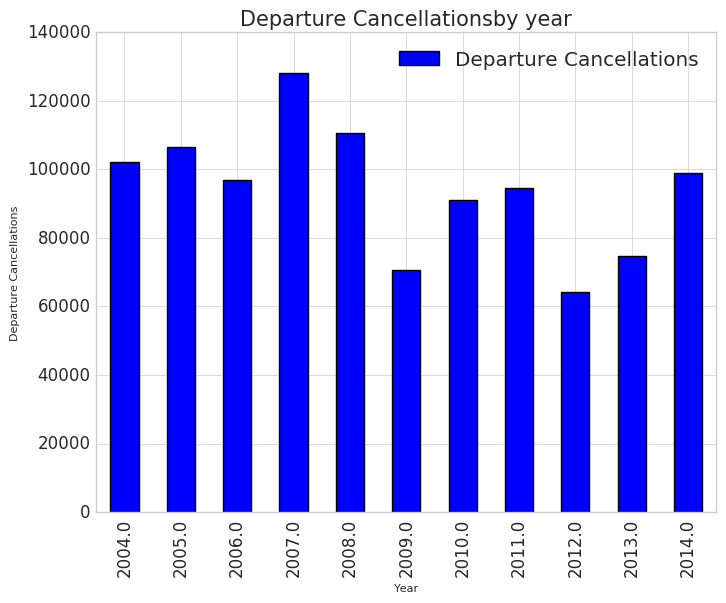

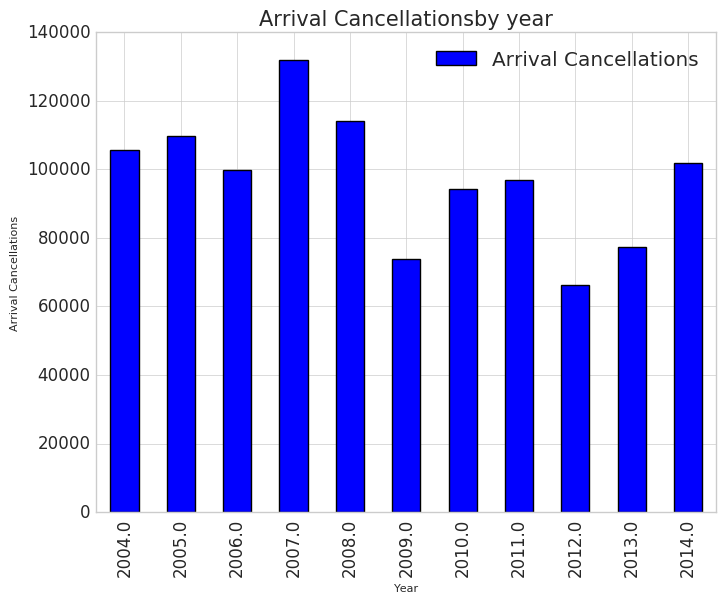

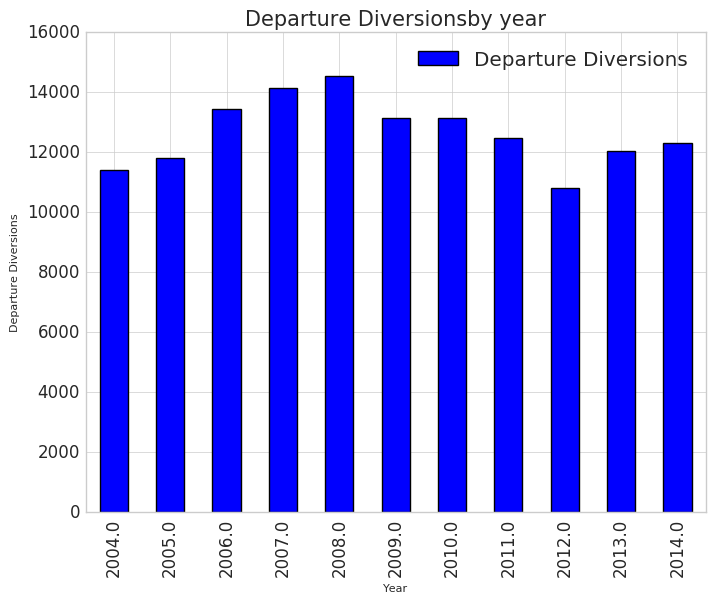

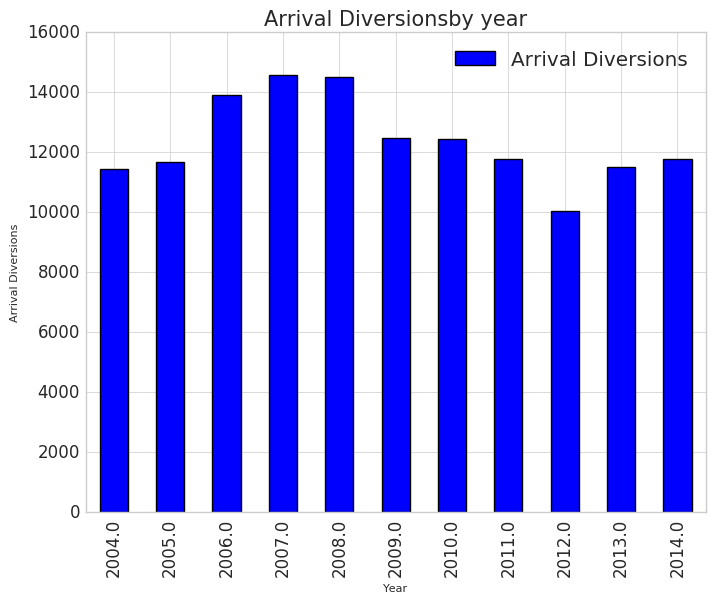

In [99]:
#Want to plot how cancellations, diversions, and % on time departures, arrivals have changed with time.
plt.style.use('seaborn-whitegrid')

#merge_airport_data['Departure Cancellations'].name

numeric_plot = [u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions', u'Arrival Diversions',
       u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay']

sum_pivot = pd.pivot_table(merge_airport_data, index = 'Year', values = numeric_plot, aggfunc = [np.sum, np.mean])

def plot_time_series(y, data):
    for i in y:
        plt.figure(figsize = (8,4))
        data.plot(kind = 'bar', x = data.index, y = i)
        plt.title(i + 'by year', fontsize = 15)
        plt.ylabel(i, fontsize = 8)
        plt.xlabel('Year', fontsize = 8)
    
plot_time_series(numeric_plot[0:4], sum_pivot[u'sum'])

#sum_pivot[u'sum'].columns

'''At a glance, while it looks like there is a correlation between arrival and departure diversions, I likely do not neat
to treat data by year too.'''

//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


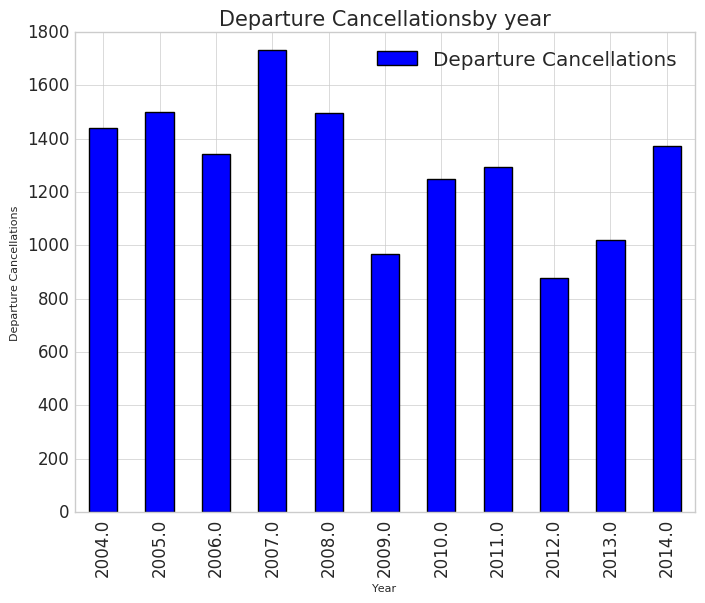

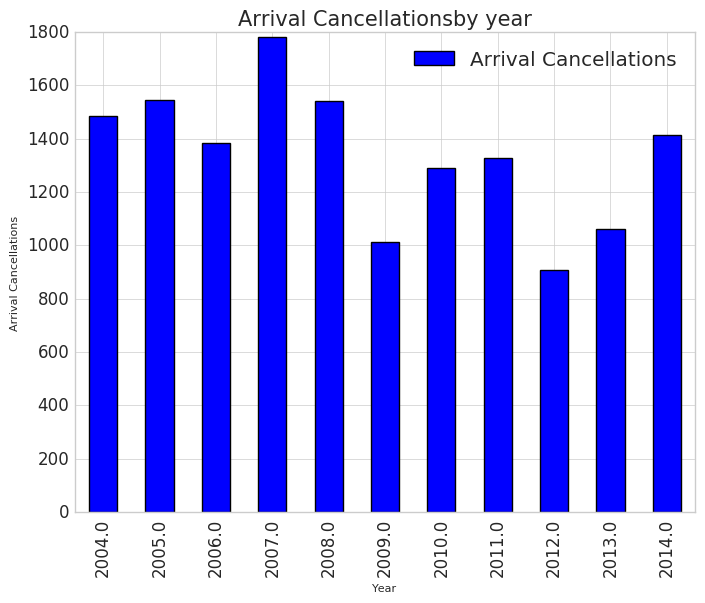

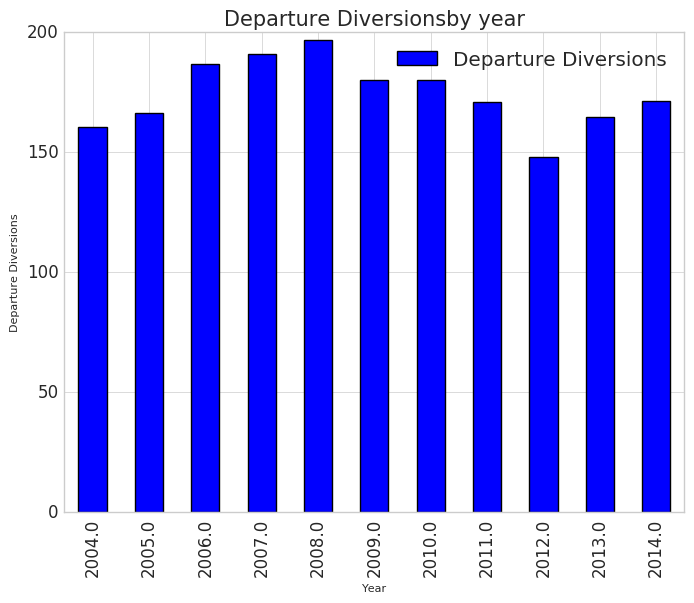

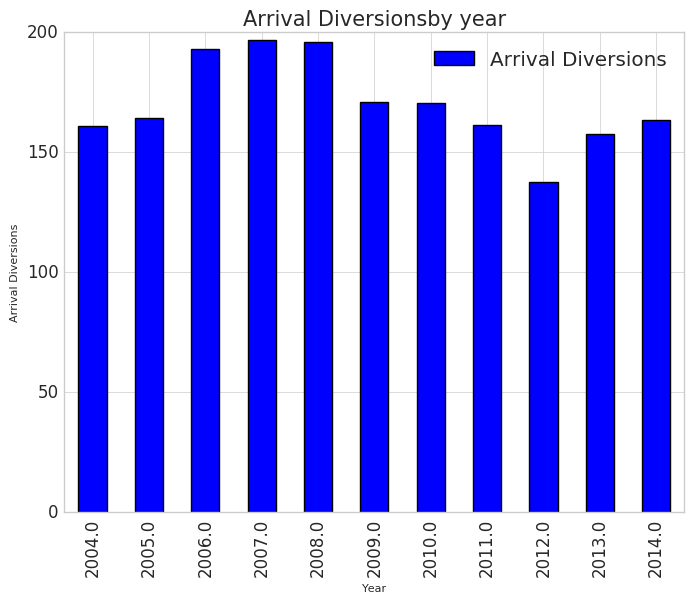

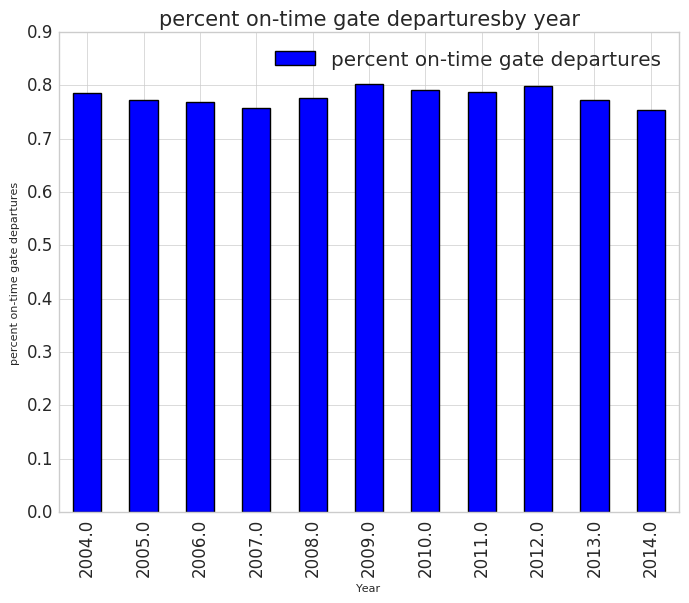

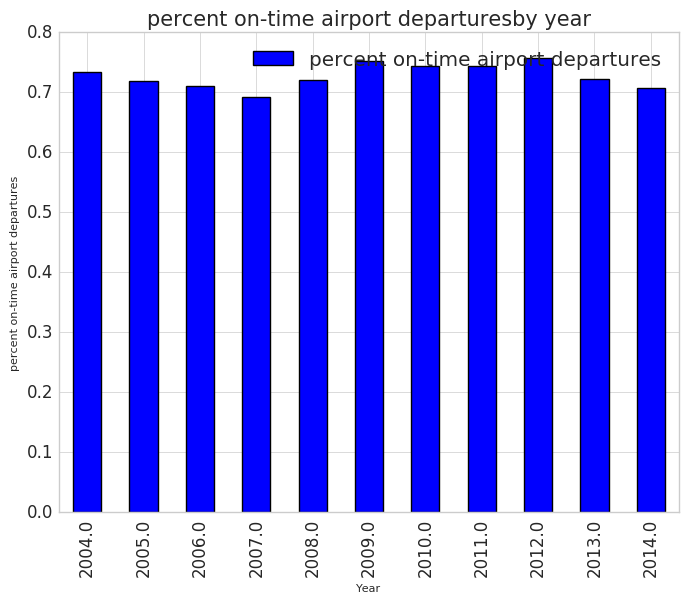

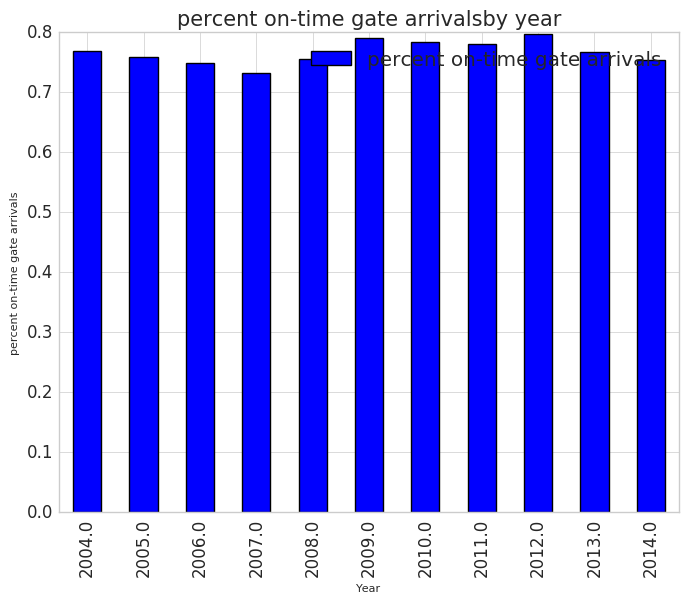

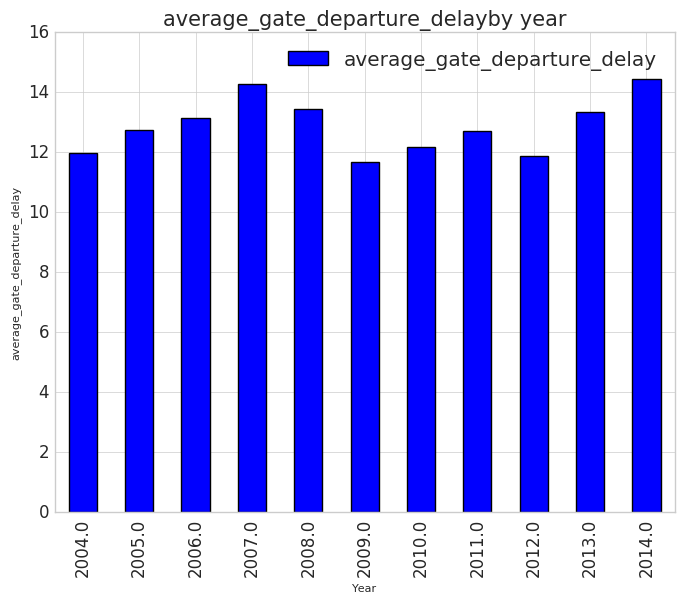

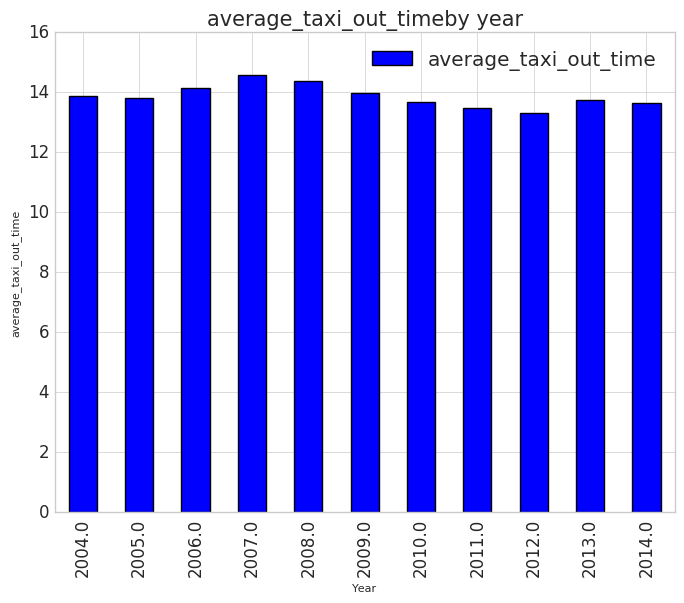

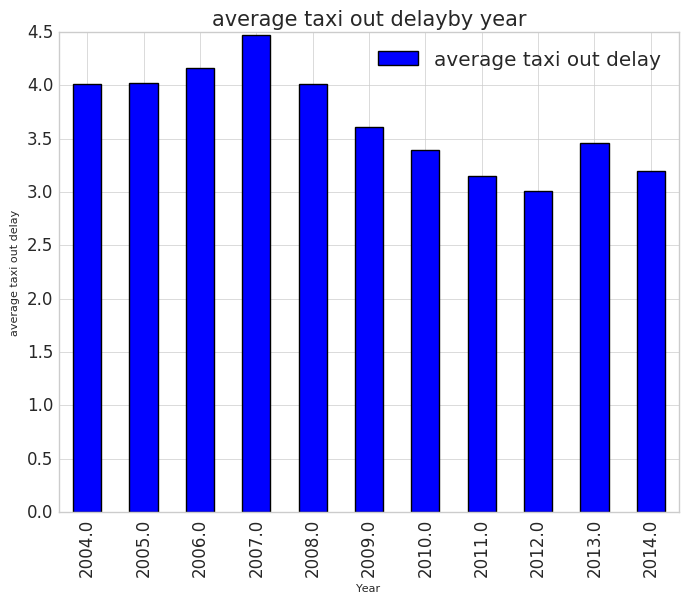

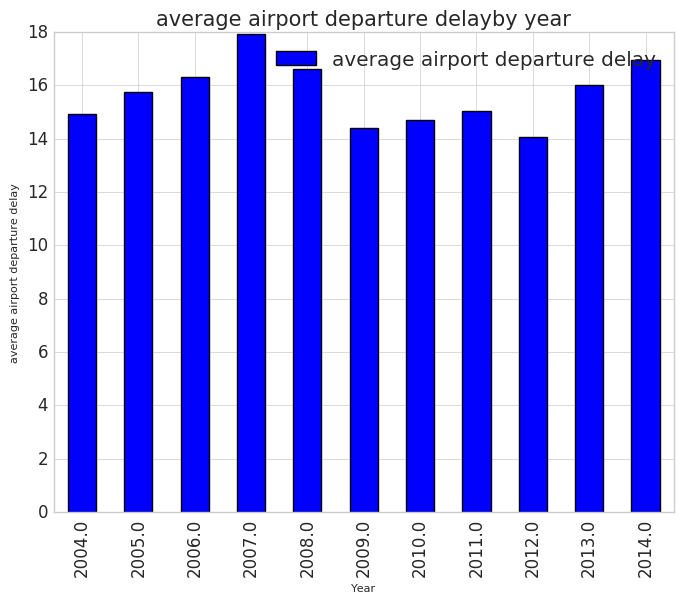

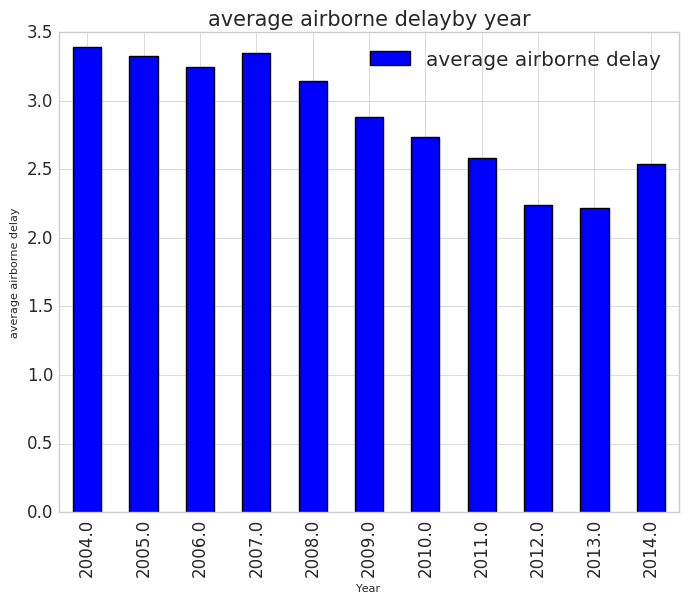

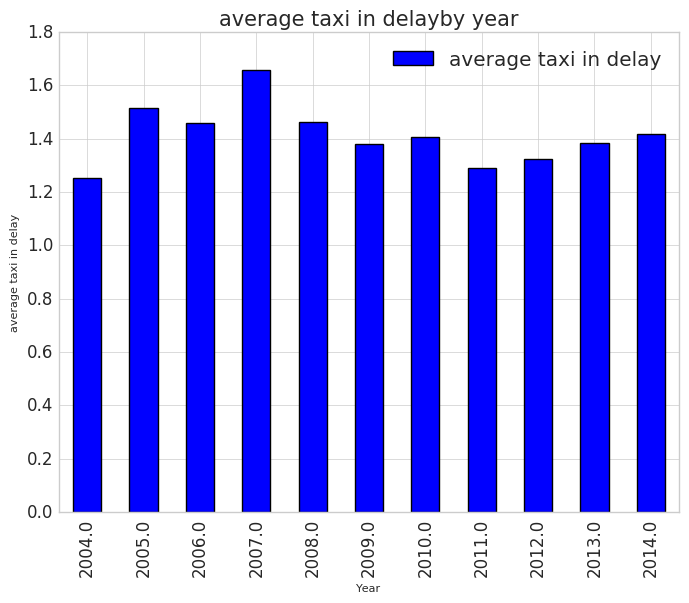

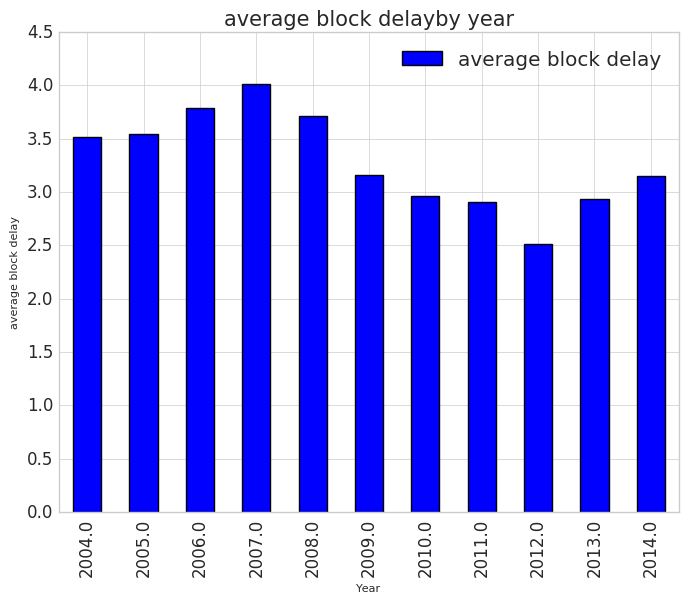

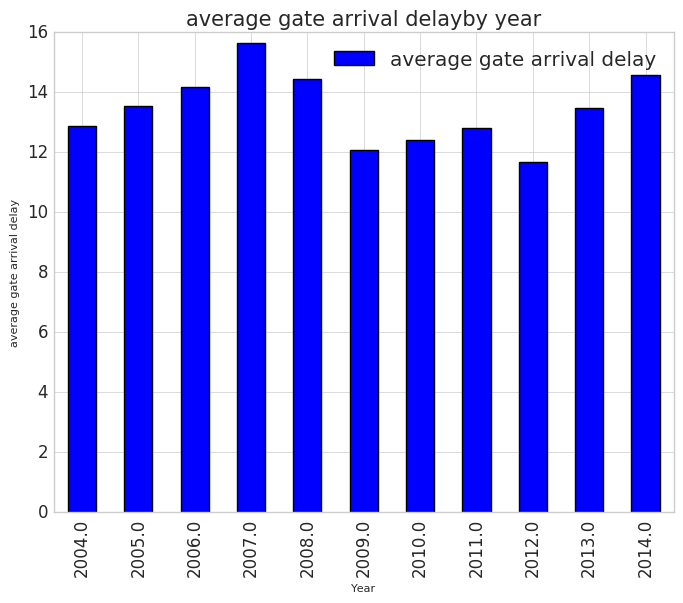

In [100]:
plot_time_series(numeric_plot, sum_pivot[u'mean'])

In [ ]:
'''Over the years, for some delays, like taxi and airtime, the average delay has gone down when looking
at airports in aggregate.''''''

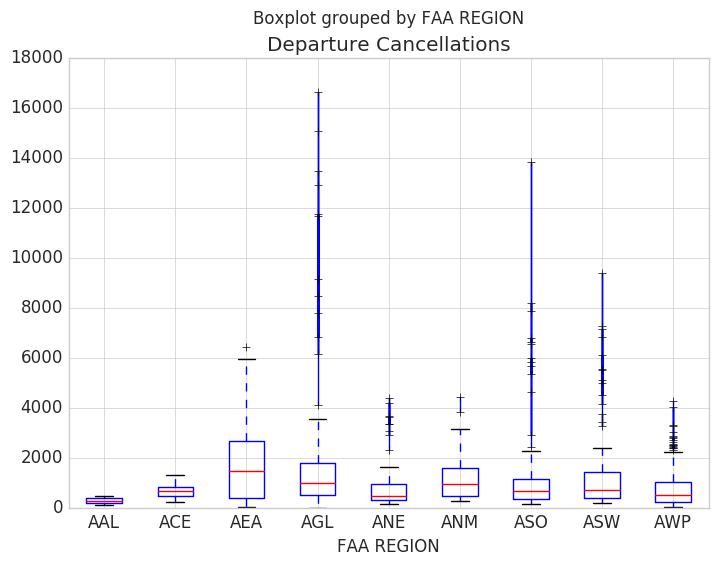

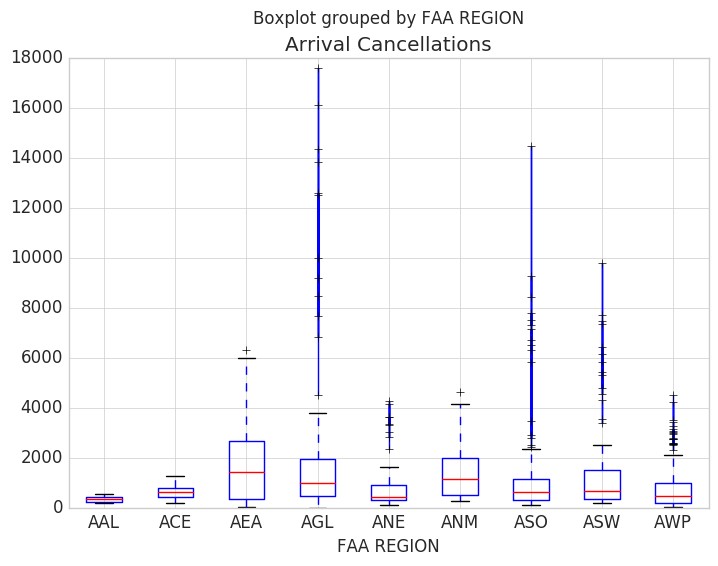

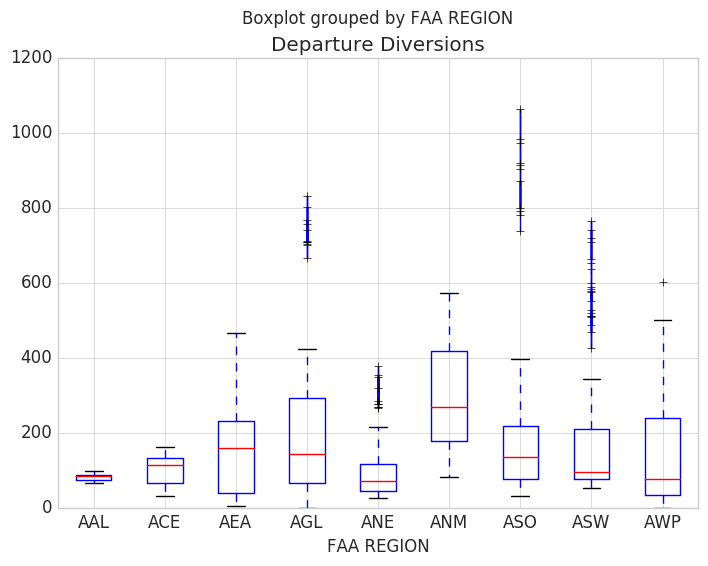

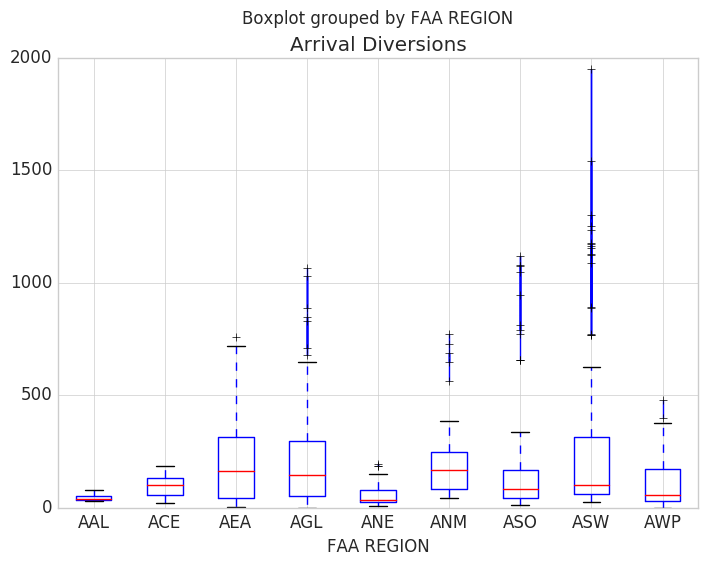

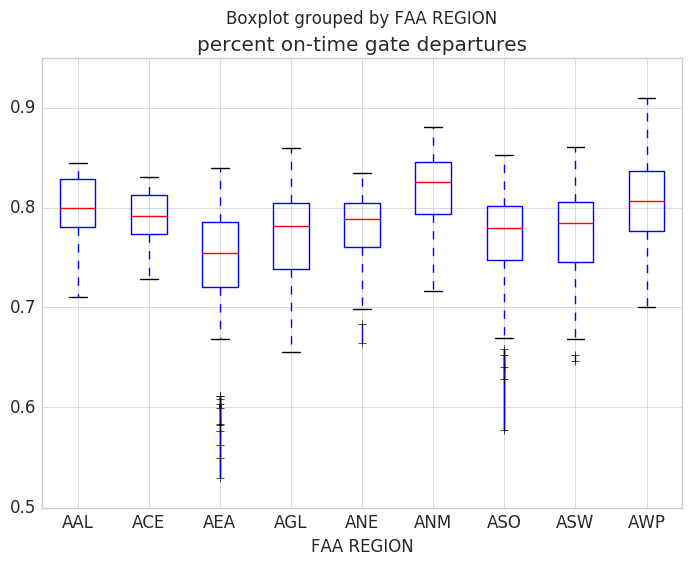

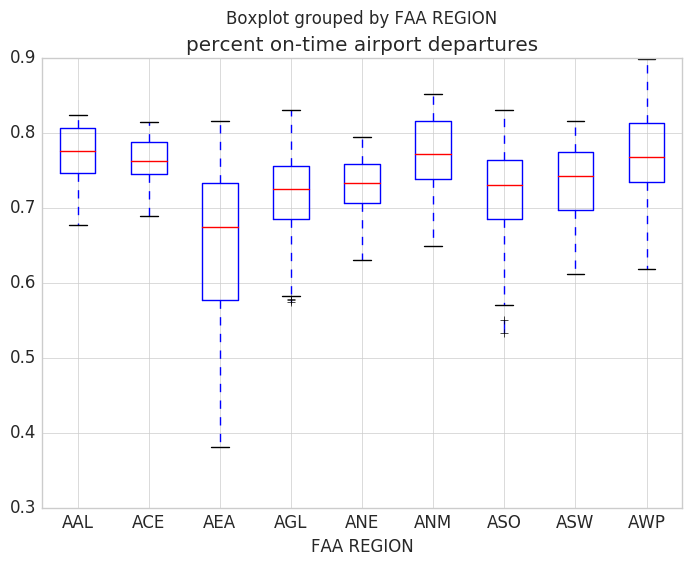

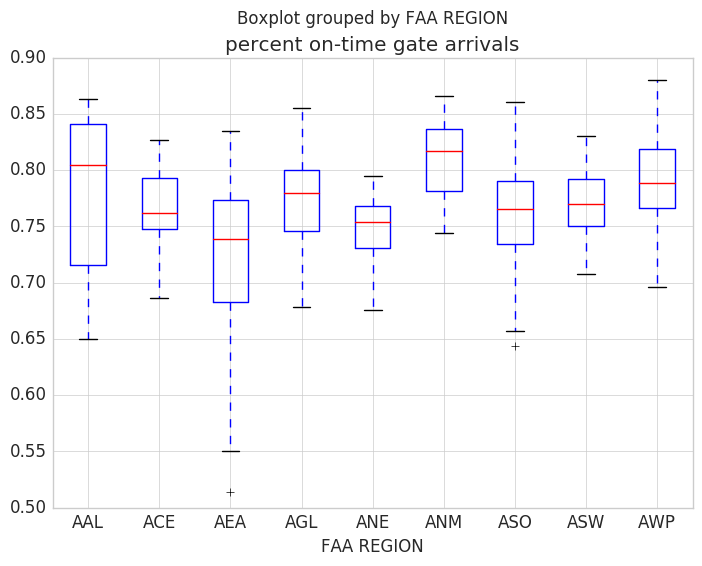

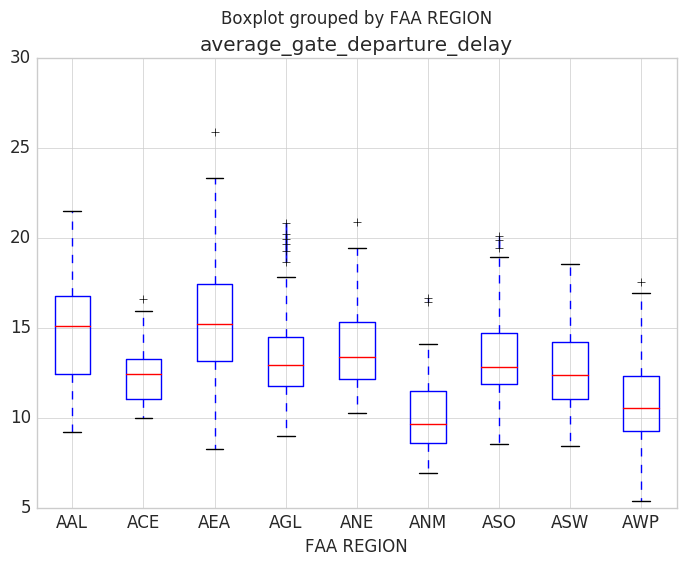

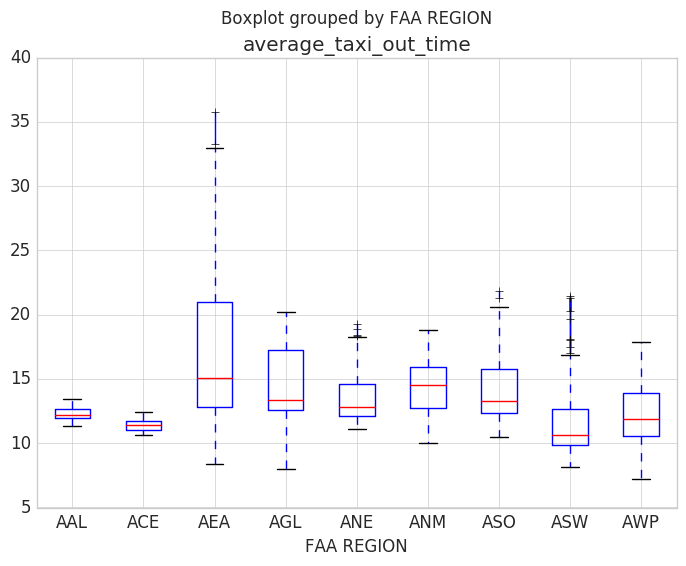

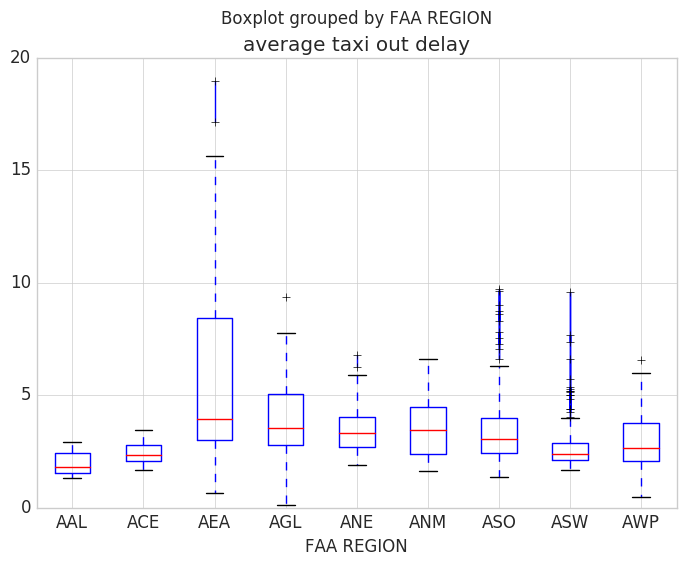

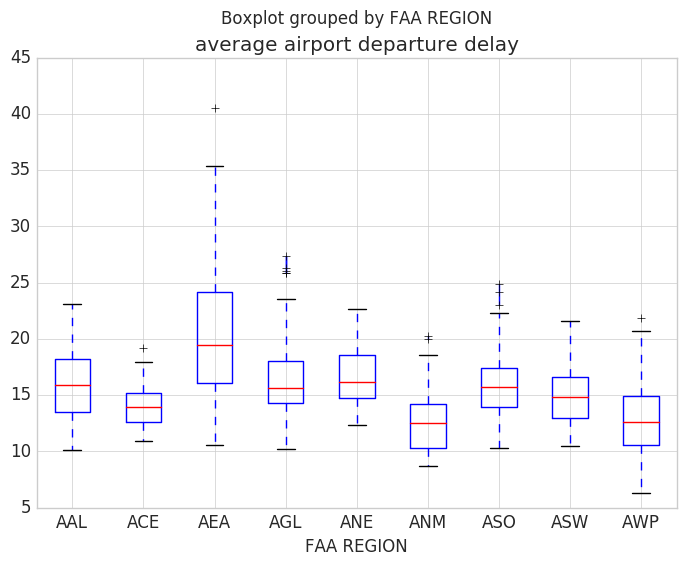

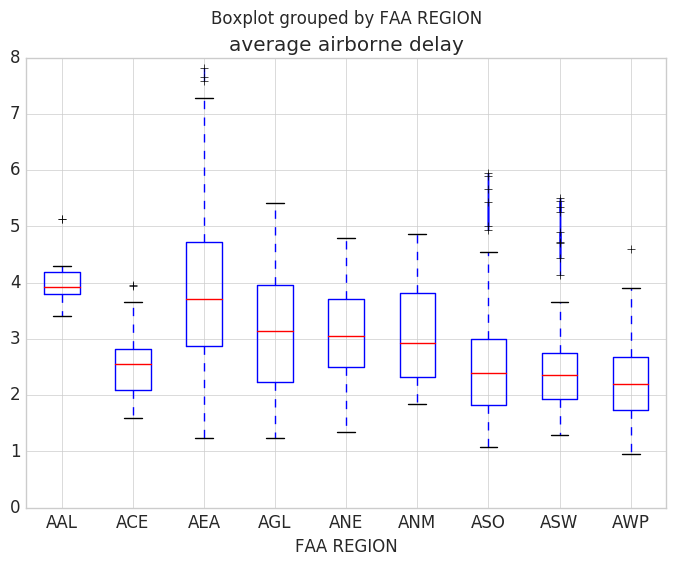

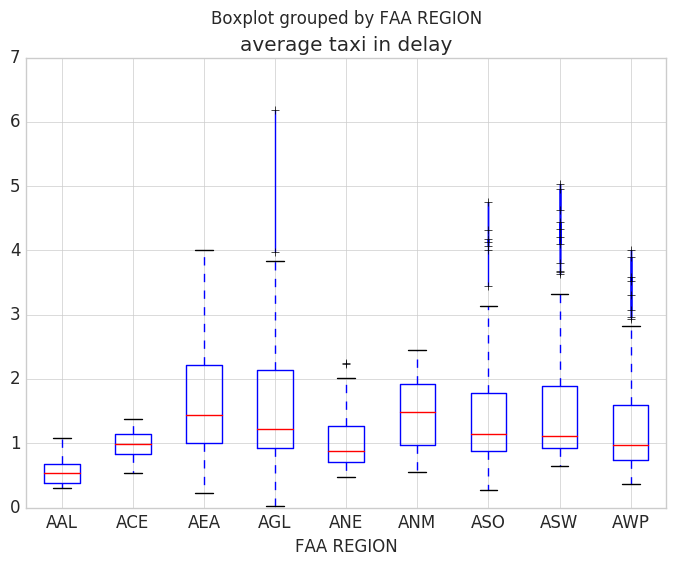

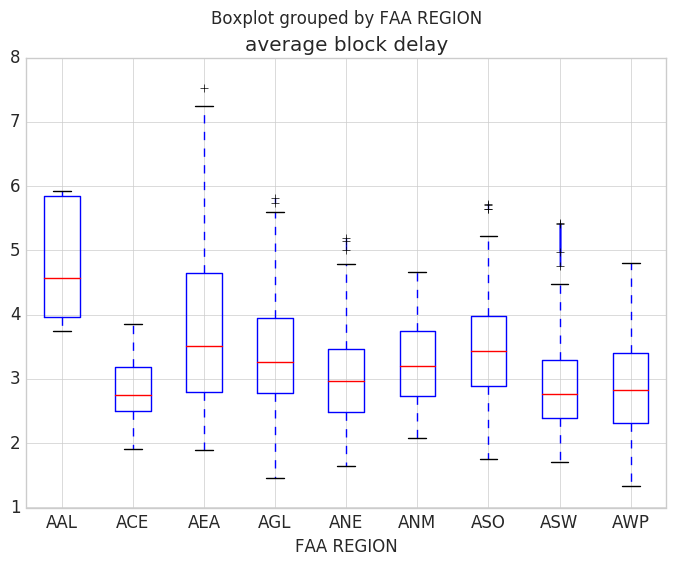

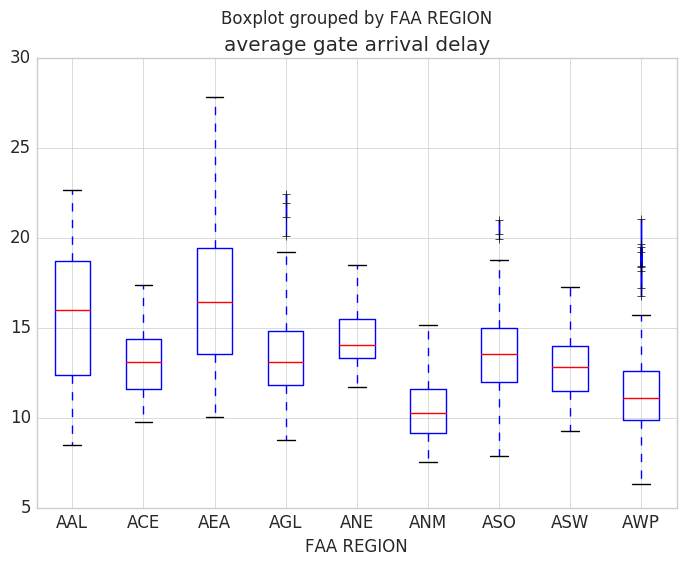

In [132]:
#Box plot of departure and arrival delays by FAA region.

for i in numeric_plot:
    merge_airport_data.boxplot(column = i, by = 'FAA REGION')
#merge_airport_data.boxplot(column = 'Arrival Cancellations', by = 'FAA REGION')


In [133]:
'''Note from the above that region definitely seems associated with differences in delays. There are also a lot
of outliers in AGL, ASO, ASW, and AWP for Departure Cancellations and Arrival Cancellations.'''

'Note from the above that region definitely seems associated with differences in delays. There are also a lot\nof outliers in AGL, ASO, ASW, and AWP for Departure Cancellations and Arrival Cancellations.'

In [136]:
merge_airport_data.dtypes

'''I might want to consider my target as factors that drive departure cancellations, or that drive
departure delay, and then replicate that for arrival delay. Those two delay times are probably
what we want to explain.'''

Airport                                object
Year                                  float64
Departure Cancellations               float64
Arrival Cancellations                 float64
Departure Diversions                  float64
Arrival Diversions                    float64
departures for metric computation       int64
arrivals for metric computation         int64
percent on-time gate departures       float64
percent on-time airport departures    float64
percent on-time gate arrivals         float64
average_gate_departure_delay          float64
average_taxi_out_time                 float64
average taxi out delay                float64
average airport departure delay       float64
average airborne delay                float64
average taxi in delay                 float64
average block delay                   float64
average gate arrival delay            float64
Key                                   float64
AP_NAME                                object
ALIAS                             

## Part 3: Data Mining

#### Are there any unique values?

In [140]:
'''Plenty of categorical data, mainly associated with the location and type of airport.

The unique values are in the airport lookup table where each row is unique to the airport. Otherwise in the data,
the unique rows are where you consider Airport + Year to be a joint identifier.'''

#Just showing for each column, groupings. I don't really find this to be of much interest compared to the plots above.

for i in merge_airport_data.columns:
    print merge_airport_data[i].value_counts()

LAS    11
STL    11
DCA    11
PVD    11
SEA    11
TPA    11
BWI    11
PHL    11
BUF    11
DAY    11
ONT    11
SAT    11
RDU    11
MEM    11
ISP    11
IAH    11
JAX    11
OAK    11
BUR    11
MHT    11
HNL    11
MKE    11
MSY    11
MIA    11
ATL    11
BOS    11
MDW    11
MSP    11
SWF    11
SAN    11
       ..
SNA    11
SDF    11
DFW    11
PHX    11
LAX    11
IND    11
ORD    11
OGG    11
RSW    11
BHM    11
PIT    11
OMA    11
MCO    11
IAD    11
SJU    11
ABQ    11
AUS    11
HOU    11
HPN    11
JFK    11
CLT    11
EWR    11
BNA    11
PBI    11
DAL    11
SLC    11
PSP     8
SMF     8
OXR     7
RFD     6
Name: Airport, dtype: int64
2008.0    74
2007.0    74
2013.0    73
2012.0    73
2011.0    73
2010.0    73
2009.0    73
2014.0    72
2006.0    72
2005.0    71
2004.0    71
Name: Year, dtype: int64
380.0      3
419.0      3
1167.0     3
1238.0     3
204.0      3
349.0      3
315.0      3
654.0      3
263.0      3
1006.0     3
446.0      3
387.0      3
427.0      3
428.0      3
918.0      3

In [227]:
merge_airport_data.info()

#Going to test at one point with airport+year as a key

#Drop key because I am not sure it really adds value. Boundary Data Available is a constant,
#so it definitely adds no value to the analysis. Also AP_NAME and Alias are identitical, and both
#are 1 to 1 with Airport. So dropping both makes sense. You can always do a merge later or a SQL join
#to get back the airport name data if you want that for final output vs the Airport Code.

#merge_airport_data.drop(['Key', 'Boundary Data Available', 'AP_NAME', 'ALIAS'], axis = 1, inplace = True)

merged_airport.drop(['Key', 'Facility Type', 'Boundary Data Available', 'AP_NAME', 'ALIAS'], axis = 1, inplace = True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 26 columns):
Airport                               799 non-null int64
Year                                  799 non-null float64
Departure Cancellations               799 non-null float64
Arrival Cancellations                 799 non-null float64
Departure Diversions                  799 non-null float64
Arrival Diversions                    799 non-null float64
departures for metric computation     799 non-null int64
arrivals for metric computation       799 non-null int64
percent on-time gate departures       799 non-null float64
percent on-time airport departures    799 non-null float64
percent on-time gate arrivals         799 non-null float64
average_gate_departure_delay          799 non-null float64
average_taxi_out_time                 799 non-null float64
average taxi out delay                799 non-null float64
average airport departure delay       799 non-null float64
average airborne

In [187]:
merge_airport_data.drop('Facility Type', axis = 1, inplace = True)

#### 3.1 Create Dummy Variables

In [197]:
#Dummy variables would be the FAA REGION, Address features like County, City, State. Airport, and AP Type too.

#I will probably use LabelEncoder for the airports
num_cols = list(merge_airport_data.describe().columns)

#Boolean column array
mask = merge_airport_data.columns.isin(num_cols)

#Getting the categorical data columns by applying the mask to the columns for the df
cat_cols = merge_airport_data.columns[~mask]
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

for i in cat_cols:
    merge_airport_data[i] = LabelEncoder().fit_transform(merge_airport_data[i])


#Could potentially make a pipeline if telling OneHotEncoder which are not categorical...


In [223]:
#Version of data with labels...
merge_airport_data


Airport    Year  Departure Cancellations  Arrival Cancellations  \
0          0  2004.0                    242.0                  235.0   
1          0  2005.0                    221.0                  190.0   
2          0  2006.0                    392.0                  329.0   
3          0  2007.0                    366.0                  304.0   
4          0  2008.0                    333.0                  300.0   
5          0  2009.0                    192.0                  162.0   
6          0  2010.0                    222.0                  177.0   
7          0  2011.0                    345.0                  294.0   
8          0  2012.0                    237.0                  181.0   
9          0  2013.0                    232.0                  212.0   
10         0  2014.0                    315.0                  274.0   
11         1  2004.0                    473.0                  532.0   
12         1  2005.0                    424.0                  484.0   
13         1  2006.0                    367.0                  436.0   
14         1  2007.0                    359.0                  423.0   
15         1  2008.0                    268.0                  355.0   
16         1  2009.0                    354.0                  421.0   
17         1  2010.0                    149.0                  204.0   
18         1  2011.0                    191.0                  265.0   
19         1  2012.0                    216.0                  284.0   
20         1  2013.0                    141.0                  184.0   
21         1  2014.0                    111.0                  162.0   
22         2  2004.0                   7870.0                 8433.0   
23         2  2005.0                  13837.0                14480.0   
24         2  2006.0                   6624.0                 7301.0   
25         2  2007.0                   6796.0                 7790.0   
26         2  2008.0                   5830.0                 6705.0   
27         2  2009.0                   5324.0                 6303.0   
28         2  2010.0                   8198.0                 9279.0   
29         2  2011.0                   6555.0                 7484.0   
..       ...     ...                      ...                    ...   
769       71  2007.0                    120.0                  103.0   
770       71  2008.0                     53.0                   41.0   
771       71  2009.0                     29.0                   18.0   
772       71  2010.0                     67.0                   54.0   
773       71  2011.0                     42.0                   40.0   
774       71  2012.0                     14.0                   12.0   
775       71  2013.0                     27.0                   23.0   
776       71  2014.0                     17.0                   11.0   
777       72  2004.0                   1167.0                 1016.0   
778       72  2005.0                    771.0                  746.0   
779       72  2006.0                    427.0                  356.0   
780       72  2007.0                    705.0                  655.0   
781       72  2008.0                    727.0                  654.0   
782       72  2009.0                    349.0                  307.0   
783       72  2010.0                    709.0                  655.0   
784       72  2011.0                    667.0                  622.0   
785       72  2012.0                    450.0                  411.0   
786       72  2013.0                    326.0                  301.0   
787       72  2014.0                    723.0                  691.0   
788       73  2004.0                    103.0                   80.0   
789       73  2005.0                    126.0                  101.0   
790       73  2006.0                    206.0                  174.0   
791       73  2007.0                    281.0                  237.0   
792       73  2008.0                    206.0

In [233]:
#Getting dummies with pd.get_dummies

#LabelEncoding the airport column.

merged_airport['Airport'] = LabelEncoder().fit_transform(merged_airport['Airport'])

dummies = pd.get_dummies(merged_airport[cat_cols], drop_first = True)

In [415]:
merged_airport['Airport'] = merged_airport_2.Airport
merged_airport

index Airport    Year  Departure Cancellations  Arrival Cancellations  \
0        0     ABQ  2004.0                    242.0                  235.0   
1        1     ABQ  2005.0                    221.0                  190.0   
2        2     ABQ  2006.0                    392.0                  329.0   
3        3     ABQ  2007.0                    366.0                  304.0   
4        4     ABQ  2008.0                    333.0                  300.0   
5        5     ABQ  2009.0                    192.0                  162.0   
6        6     ABQ  2010.0                    222.0                  177.0   
7        7     ABQ  2011.0                    345.0                  294.0   
8        8     ABQ  2012.0                    237.0                  181.0   
9        9     ABQ  2013.0                    232.0                  212.0   
10      10     ABQ  2014.0                    315.0                  274.0   
11      11     ANC  2004.0                    473.0                  532.0   
12      12     ANC  2005.0                    424.0                  484.0   
13      13     ANC  2006.0                    367.0                  436.0   
14      14     ANC  2007.0                    359.0                  423.0   
15      15     ANC  2008.0                    268.0                  355.0   
16      16     ANC  2009.0                    354.0                  421.0   
17      17     ANC  2010.0                    149.0                  204.0   
18      18     ANC  2011.0                    191.0                  265.0   
19      19     ANC  2012.0                    216.0                  284.0   
20      20     ANC  2013.0                    141.0                  184.0   
21      21     ANC  2014.0                    111.0                  162.0   
22      22     ATL  2004.0                   7870.0                 8433.0   
23      23     ATL  2005.0                  13837.0                14480.0   
24      24     ATL  2006.0                   6624.0                 7301.0   
25      25     ATL  2007.0                   6796.0                 7790.0   
26      26     ATL  2008.0                   5830.0                 6705.0   
27      27     ATL  2009.0                   5324.0                 6303.0   
28      28     ATL  2010.0                   8198.0                 9279.0   
29      29     ATL  2011.0                   6555.0                 7484.0   
..     ...     ...     ...                      ...                    ...   
769    769     SWF  2007.0                    120.0                  103.0   
770    770     SWF  2008.0                     53.0                   41.0   
771    771     SWF  2009.0                     29.0                   18.0   
772    772     SWF  2010.0                     67.0                   54.0   
773    773     SWF  2011.0                     42.0                   40.0   
774    774     SWF  2012.0                     14.0                   12.0   
775    775     SWF  2013.0                     27.0                   23.0   
776    776     SWF  2014.0                     17.0                   11.0   
777    777     TPA  2004.0                   1167.0                 1016.0   
778    778     TPA  2005.0                    771.0                  746.0   
779    779     TPA  2006.0                    427.0                  356.0   
780    780     TPA  2007.0                    705.0                  655.0   
781    781     TPA  2008.0                    727.0                  654.0   
782    782     TPA  2009.0                    349.0                  307.0   
783    783     TPA  2010.0                    709.0                  655.0   
784    784     TPA  2011.0                    667.0                  622.0   
785    785     TPA  2012.0                    450.0                  411.0   
786    786     TPA  2013.0                    326.0                  301.0   
787    787     TPA  2014.0                    723.0                  691.0   
788    788     TUS  2004.0 

#### 3.2 Format the data

In [241]:
#Joining dummies and numerical back...

merged_airport[num_cols]

merged_airport_dummies = pd.merge(dummies, merged_airport[num_cols], right_index = True, left_index = True)

## Part 4: Refine the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell?

In [270]:
#chi2 dist here on random sample of each variable.

testnorm = []
for i in num_cols:
    testnorm.append((i,  normaltest(merged_airport_dummies[num_cols][i].sample(n=50, replace = True))[1]))
    
normal_test_results = pd.DataFrame(testnorm, columns = ['Feature', 'P-Value'])
    #print (i, normaltest(merged_airport_dummies[i], axis = None))

#Which features have a p-value greater than 0.05, and hence we can not reject the null that the dist is normal?    
normal = lambda x: True if x >= 0.05 else False
normal_test_results['Normal'] =  normal_test_results['P-Value'].apply(normal)

print "These are the features for which we could not reject the normal distribution null hypothesis."
print "----"
for i in normal_test_results.index:
    if normal_test_results.Normal[i] == True:
        print normal_test_results.Feature[i]
print "----"
print 
print "We are assessing normality by p-value with a 5% threshold for rejecting the null that the distribution is normal. Below are the test results for all numeric features."
normal_test_results

These are the features for which we could not reject the normal distribution null hypothesis.
----
arrivals for metric computation
percent on-time airport departures
percent on-time gate arrivals
average_gate_departure_delay
average airborne delay
average block delay
----

We are assessing normality by p-value with a 5% threshold for rejecting the null that the distribution is normal. Below are the test results for all numeric features.


Feature       P-Value Normal
0                                 Year  2.738780e-03  False
1              Departure Cancellations  4.566707e-08  False
2                Arrival Cancellations  2.398845e-14  False
3                 Departure Diversions  1.488270e-07  False
4                   Arrival Diversions  2.659517e-12  False
5    departures for metric computation  4.323725e-06  False
6      arrivals for metric computation  7.171013e-02   True
7      percent on-time gate departures  1.271534e-02  False
8   percent on-time airport departures  1.313864e-01   True
9        percent on-time gate arrivals  3.548457e-01   True
10        average_gate_departure_delay  3.404124e-01   True
11               average_taxi_out_time  5.550175e-07  False
12              average taxi out delay  2.108085e-12  False
13     average airport departure delay  1.384069e-07  False
14              average airborne delay  1.571405e-01   True
15               average taxi in delay  4.171194e-08  False
16                 average block delay  2.379489e-01   True
17          average gate arrival delay  3.802084e-06  False
18                            Latitude  3.552191e-02  False
19                           Longitude  5.582225e-04  False

In [253]:
'''If a distribution is normal, then variance does describe how much of a spread it potentially has.
This is what we are seeking to maximize for PCA. However, PCA does not require normality in its assumptions.
It does require:

1) Linearity in the features;
2) Large variances define importance (so normality helps here, but if our distribution is not 
normal but variance still describes importance, this likely is fine);
3) Principal Components are orthogonal to each other.


Having a normally distributed variable helps with assumption 2.

'''

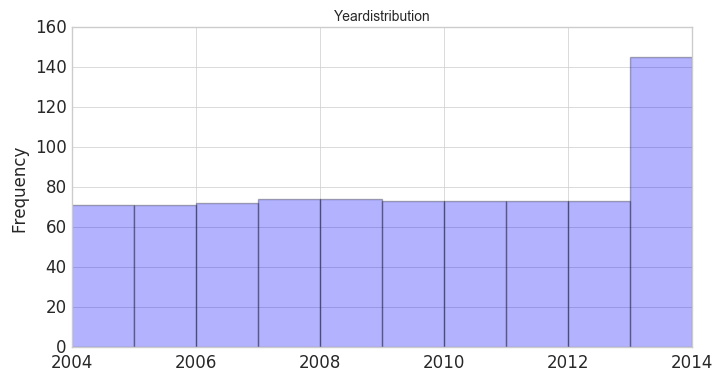

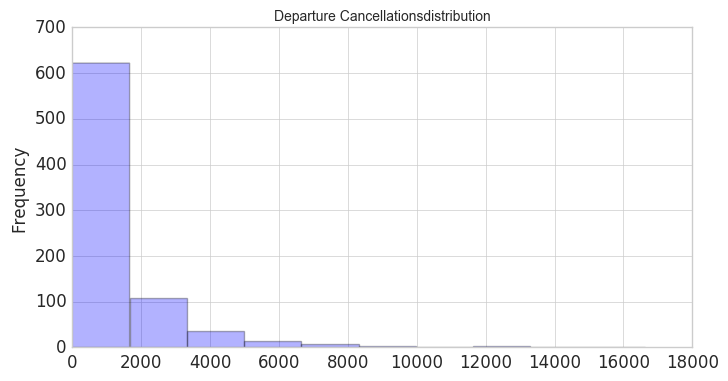

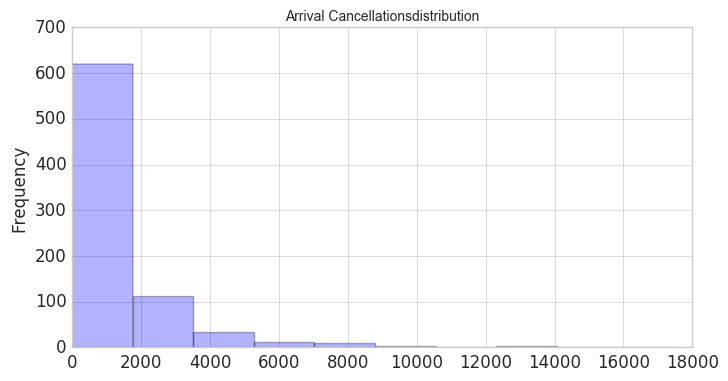

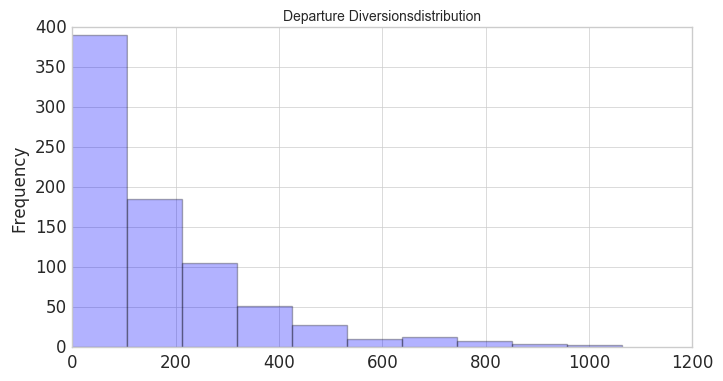

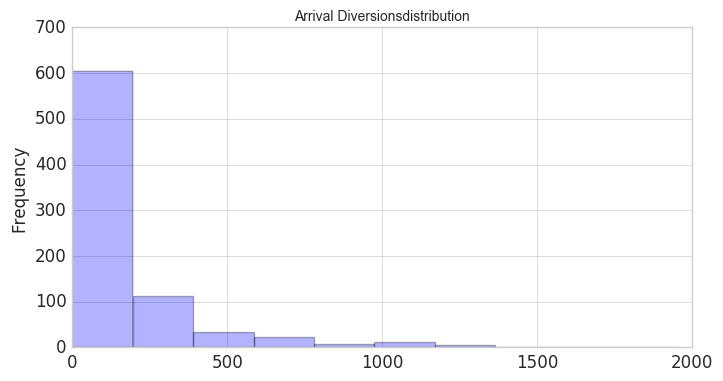

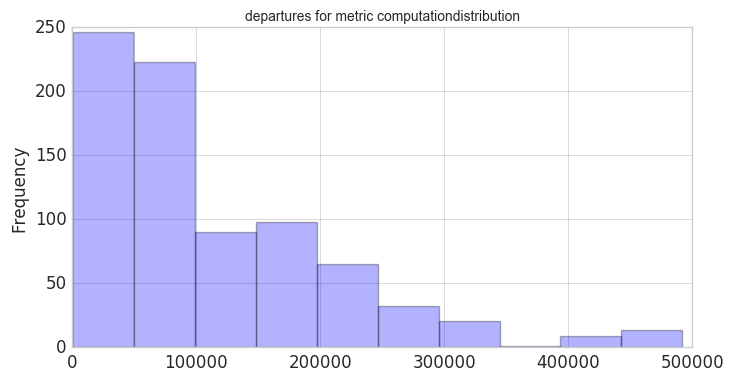

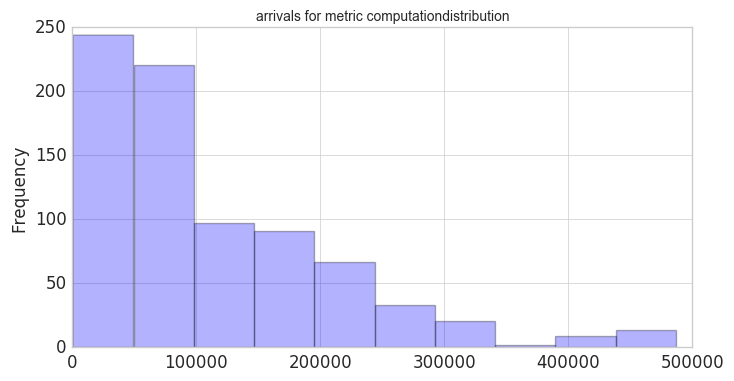

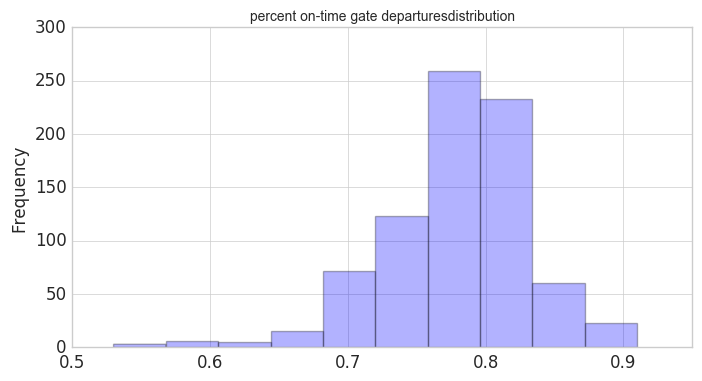

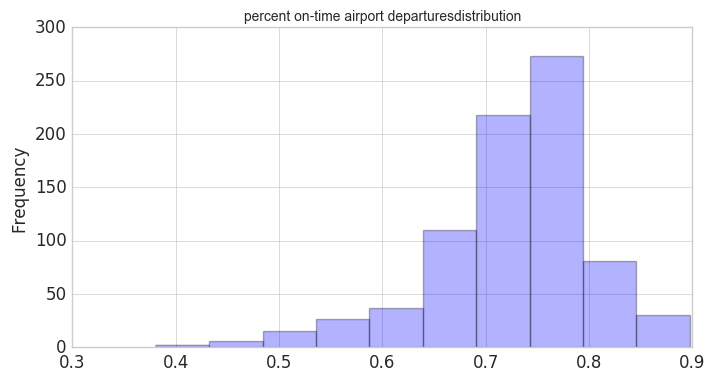

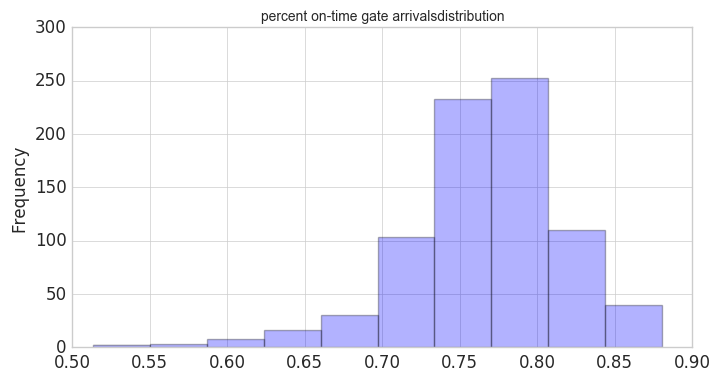

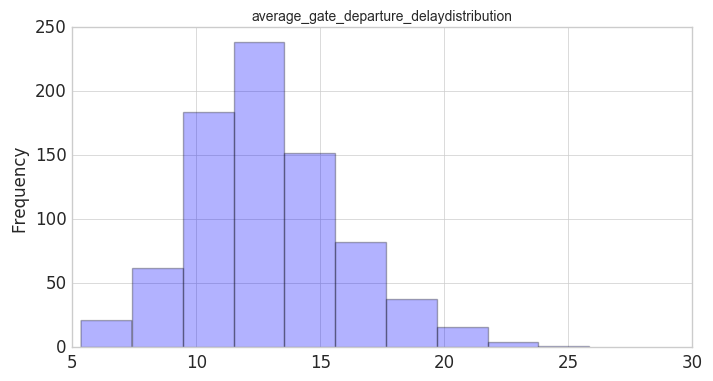

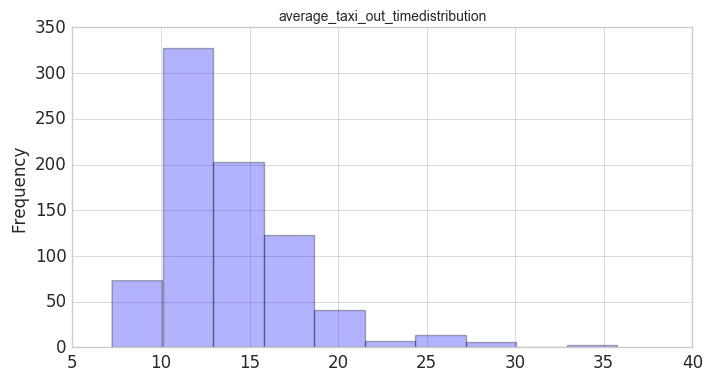

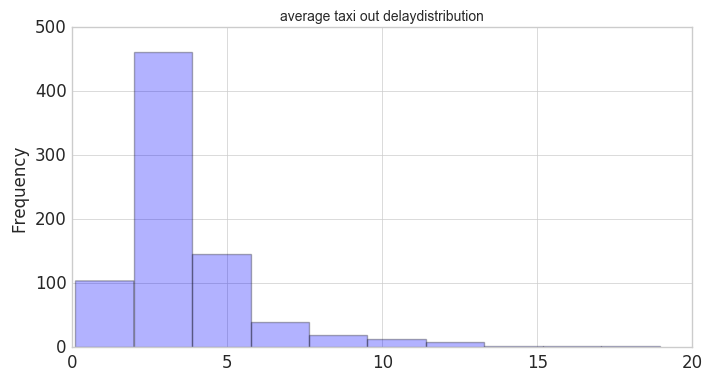

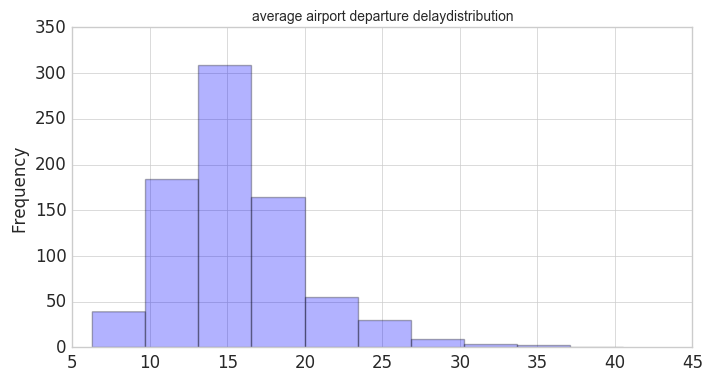

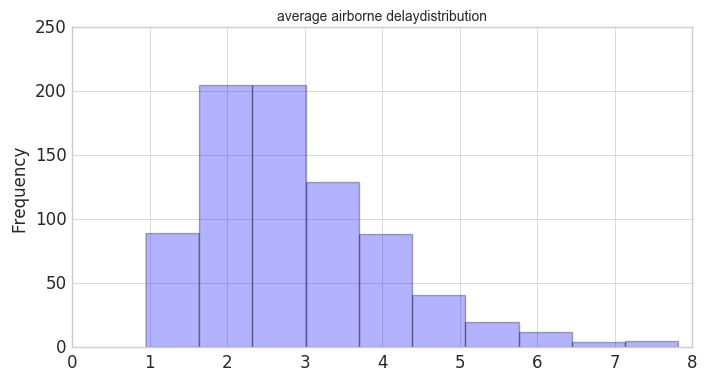

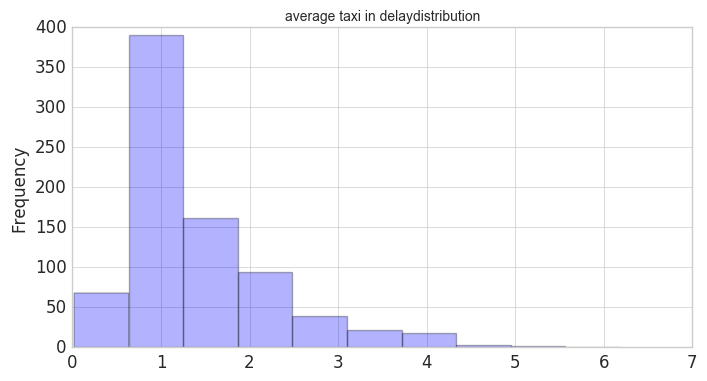

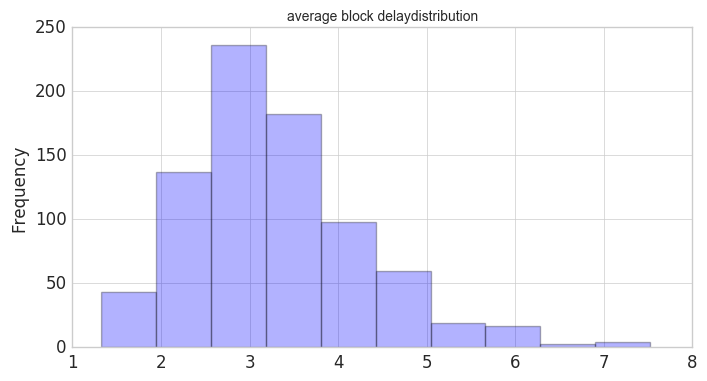

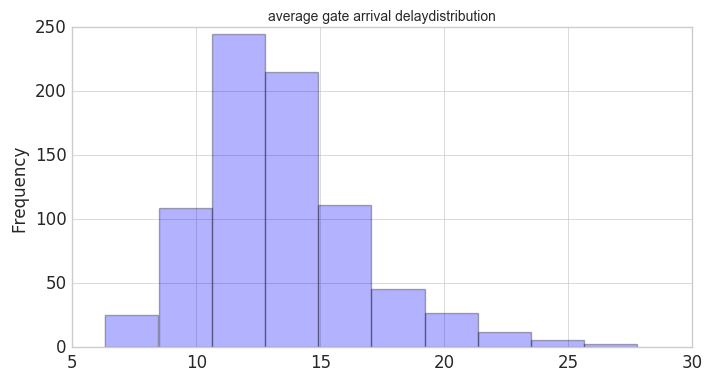

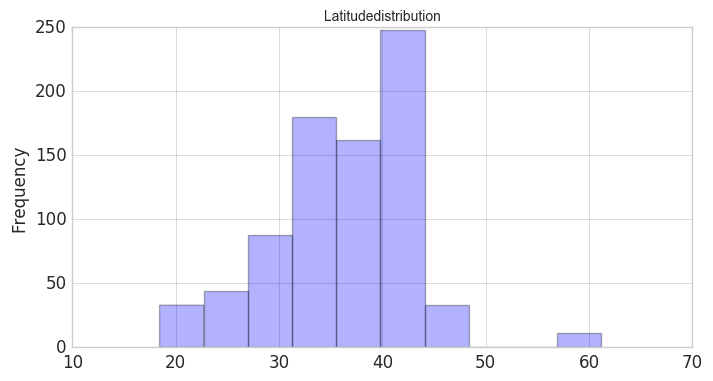

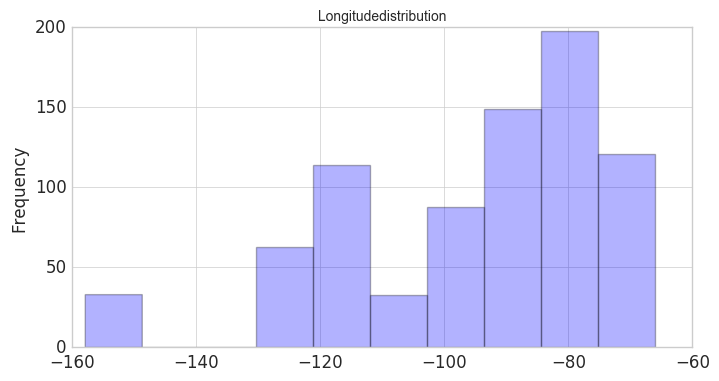

In [273]:
#Also check histograms

'''As suspected, a large number of the numerical features do not appear to be normally distributed.

However, the features from the operations data mostly appear to be Gaussian. The cancellations/diversions
numerical data does not appear Gaussian at all. I am going to make the call that even with skew, the operations data,
including all the average delays, is usable for PCA since it looks Gaussian enough, even though from the p-values, most
would be rejected. After all, there still is a large amount of spread for those and a Gaussian shape.

What I will not include in the analysis is the Departures/Arrivals Cancellations/Diversions. Besides, this data
is captured in the Percent On-Time Departures and Arrivals, which does look normally distributed.'''

for i in merged_airport_dummies[num_cols]:
    plt.figure(figsize = (8, 4))
    merged_airport_dummies[i].plot(kind = 'hist', alpha = 0.3)
    plt.title(i + ' distribution', fontsize = 10)

#### 4.2 Find correlations in the data

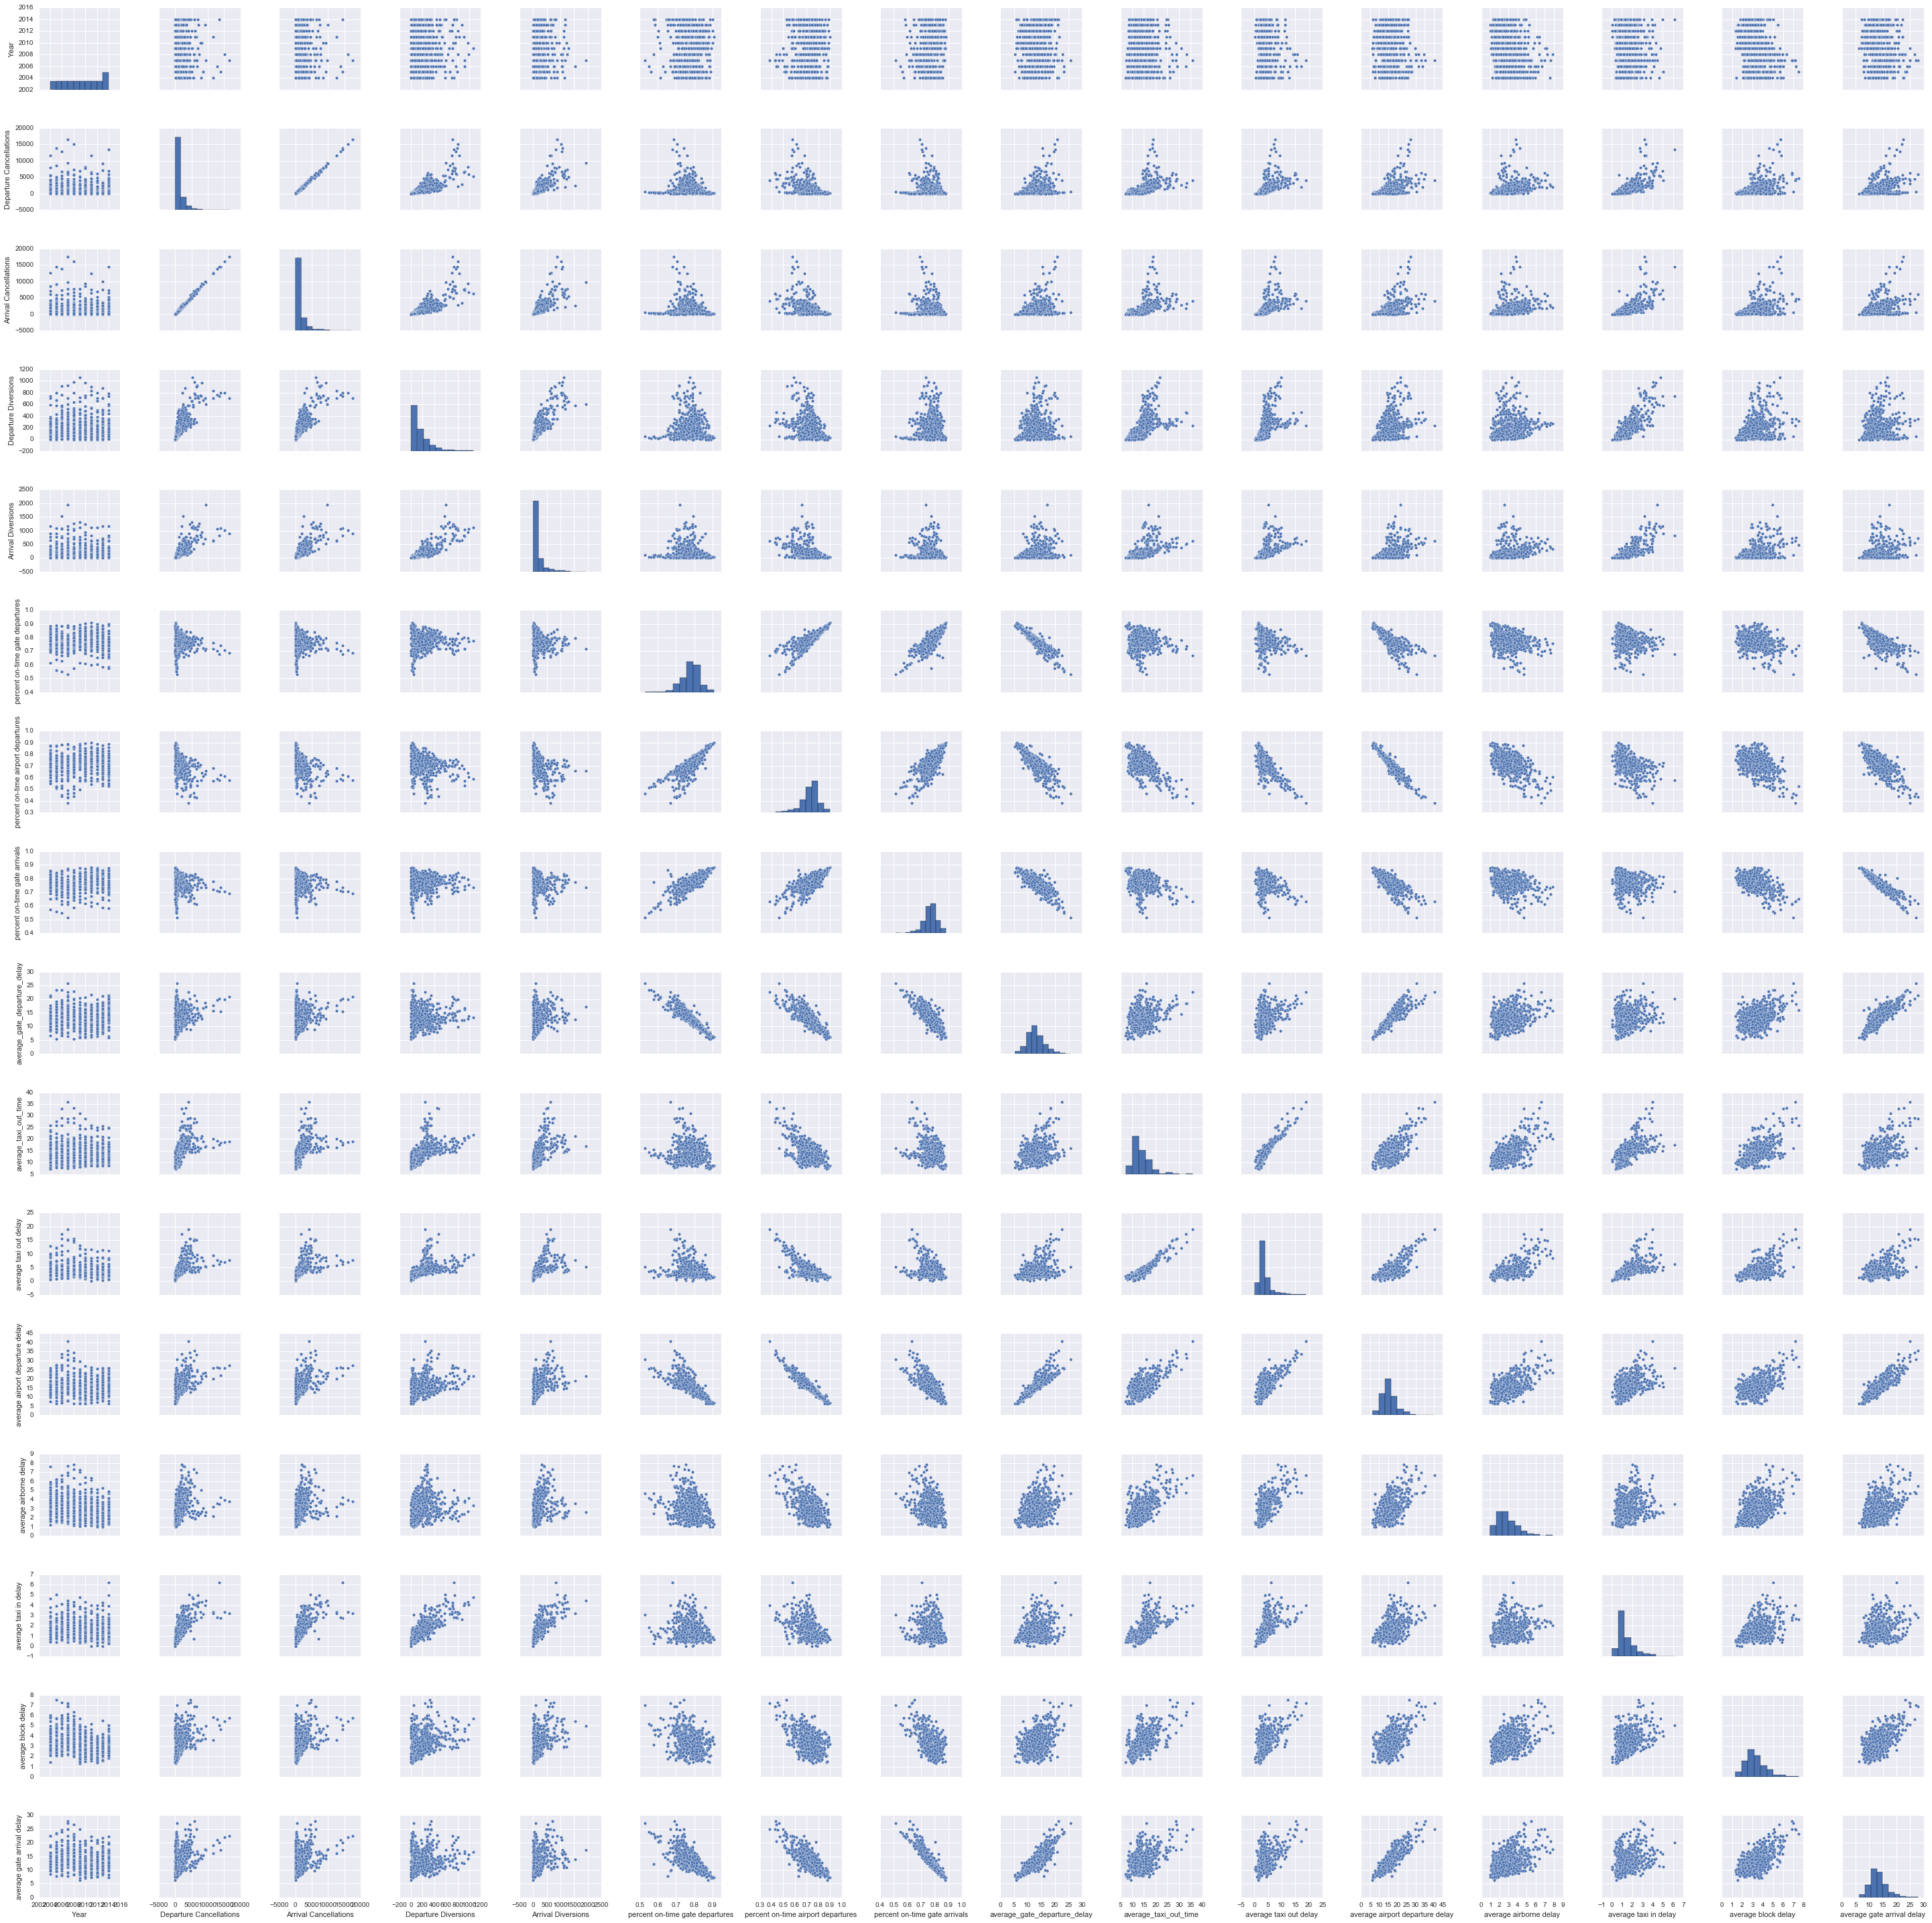

In [279]:
#Looking first at the original numerical columns
cols = ['Year',
 'Departure Cancellations',
 'Arrival Cancellations',
 'Departure Diversions',
 'Arrival Diversions',
 'percent on-time gate departures',
 'percent on-time airport departures',
 'percent on-time gate arrivals',
 'average_gate_departure_delay',
 'average_taxi_out_time',
 'average taxi out delay',
 'average airport departure delay',
 'average airborne delay',
 'average taxi in delay',
 'average block delay',
 'average gate arrival delay']

plt.figure(figsize = (20,20))
sns.pairplot(merged_airport[cols])

#Pretty useless to look at. Pare down the view...

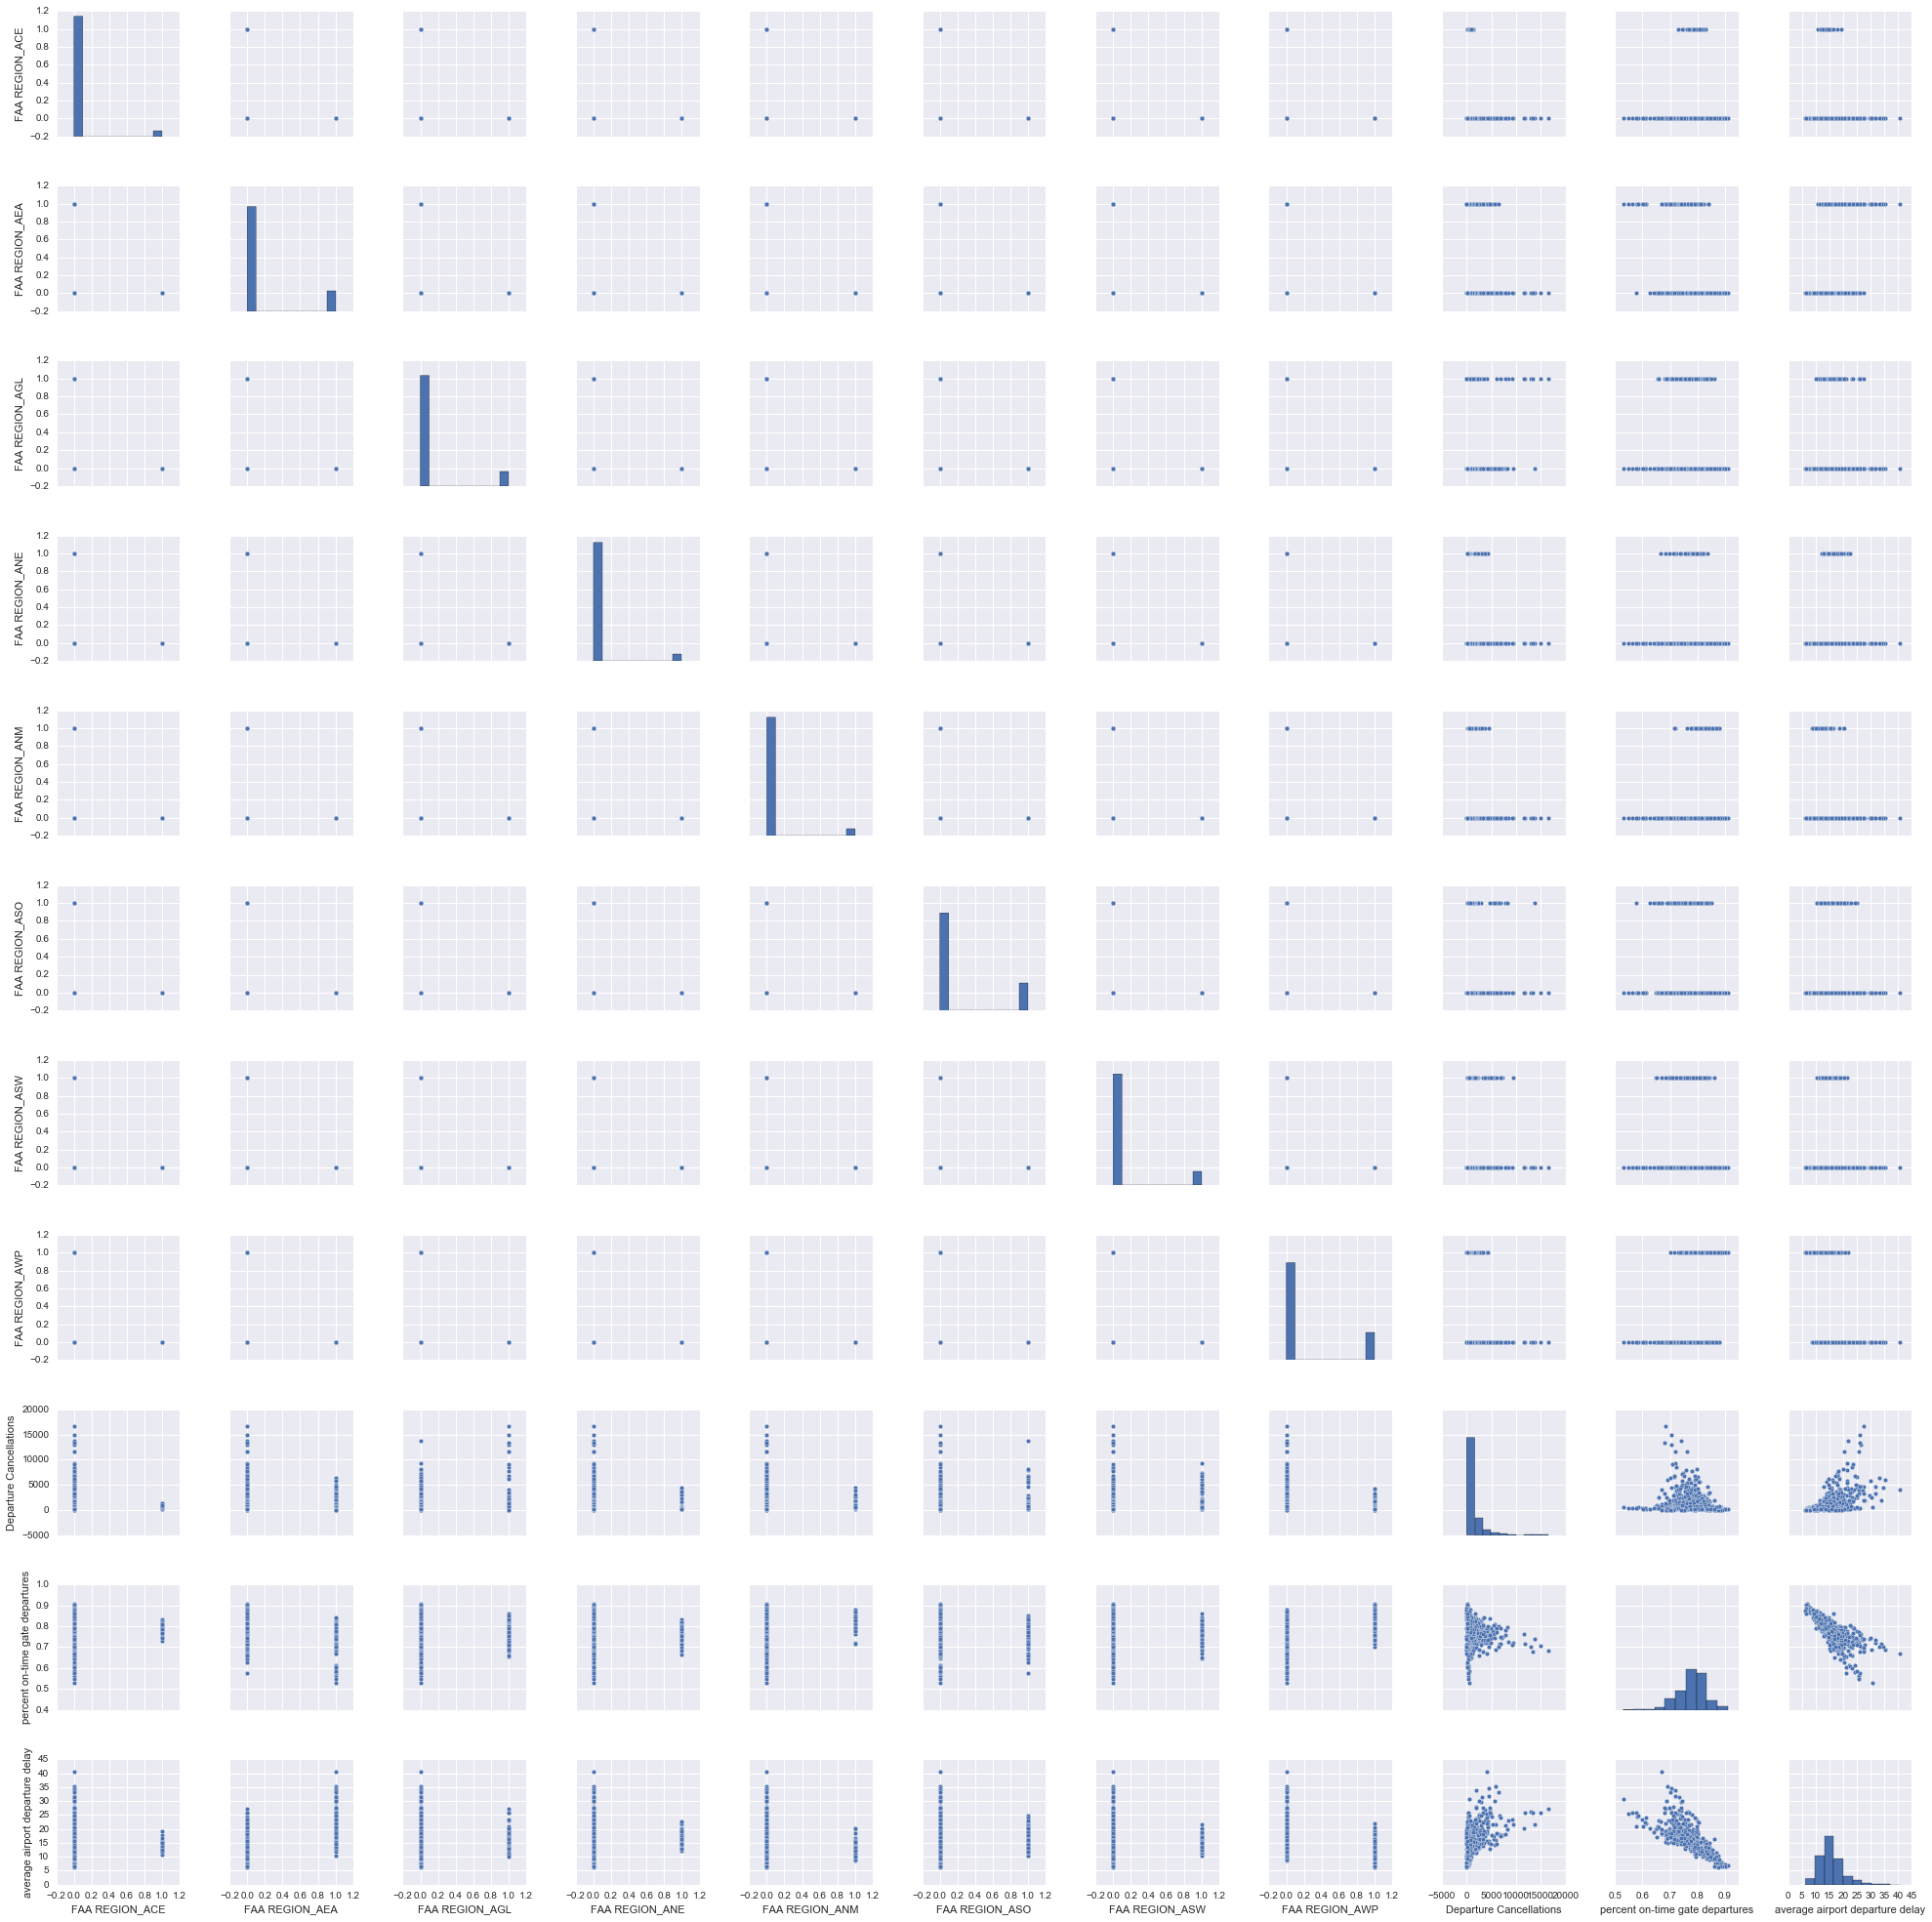

In [289]:
#Also interesting to see correlations among categorical columns

sns.pairplot(merged_airport_dummies[[u'FAA REGION_ACE', u'FAA REGION_AEA', u'FAA REGION_AGL',
       u'FAA REGION_ANE', u'FAA REGION_ANM', u'FAA REGION_ASO',
       u'FAA REGION_ASW', u'FAA REGION_AWP', 'Departure Cancellations', 'percent on-time gate departures',
 'average airport departure delay']])

'''This is what happens with binary variables...interesting to see via this how some regions have worse delays than others.'''

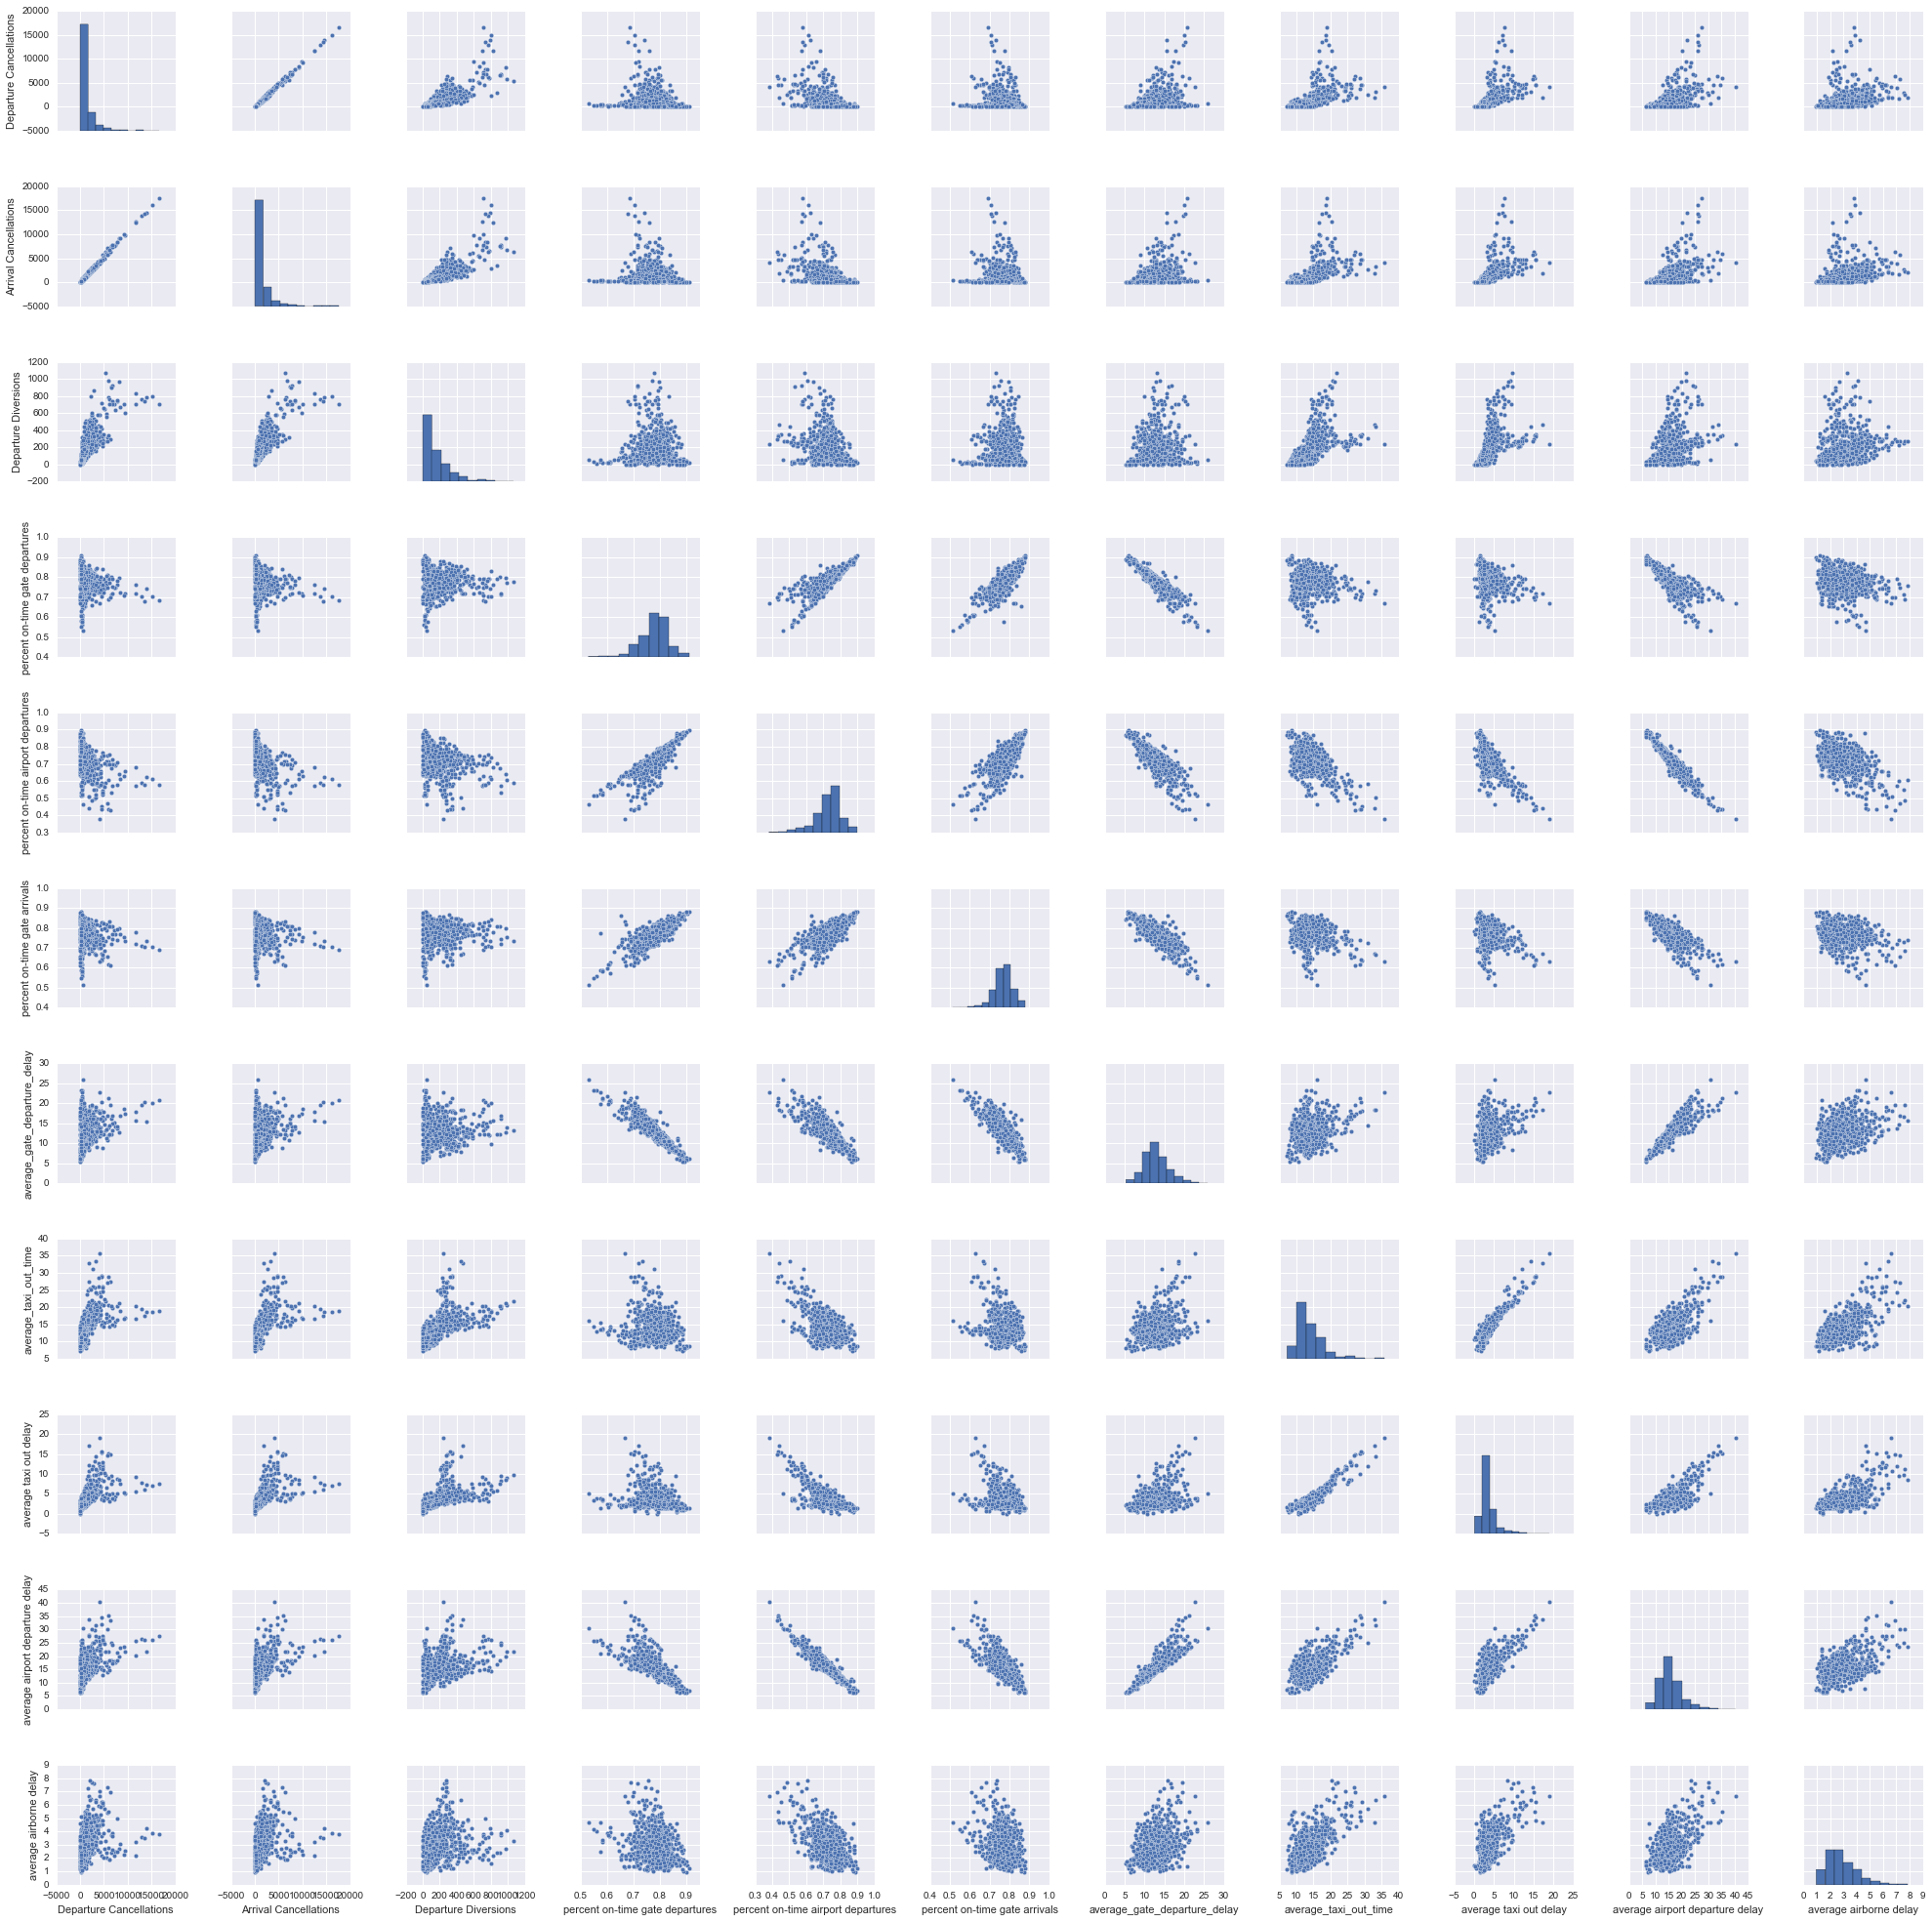

In [280]:
#Pared down pairplot of numerical data for departures.

'''At a glance, a number of the variables look like they have a linear relationship. But some don't -
i.e. departure diversions and on-time gate departures'''

cols = [
 'Departure Cancellations',
 'Arrival Cancellations',
 'Departure Diversions',
 'percent on-time gate departures',
 'percent on-time airport departures',
 'percent on-time gate arrivals',
 'average_gate_departure_delay',
 'average_taxi_out_time',
 'average taxi out delay',
 'average airport departure delay',
 'average airborne delay']

plt.figure(figsize = (20,20))
sns.pairplot(merged_airport[cols])

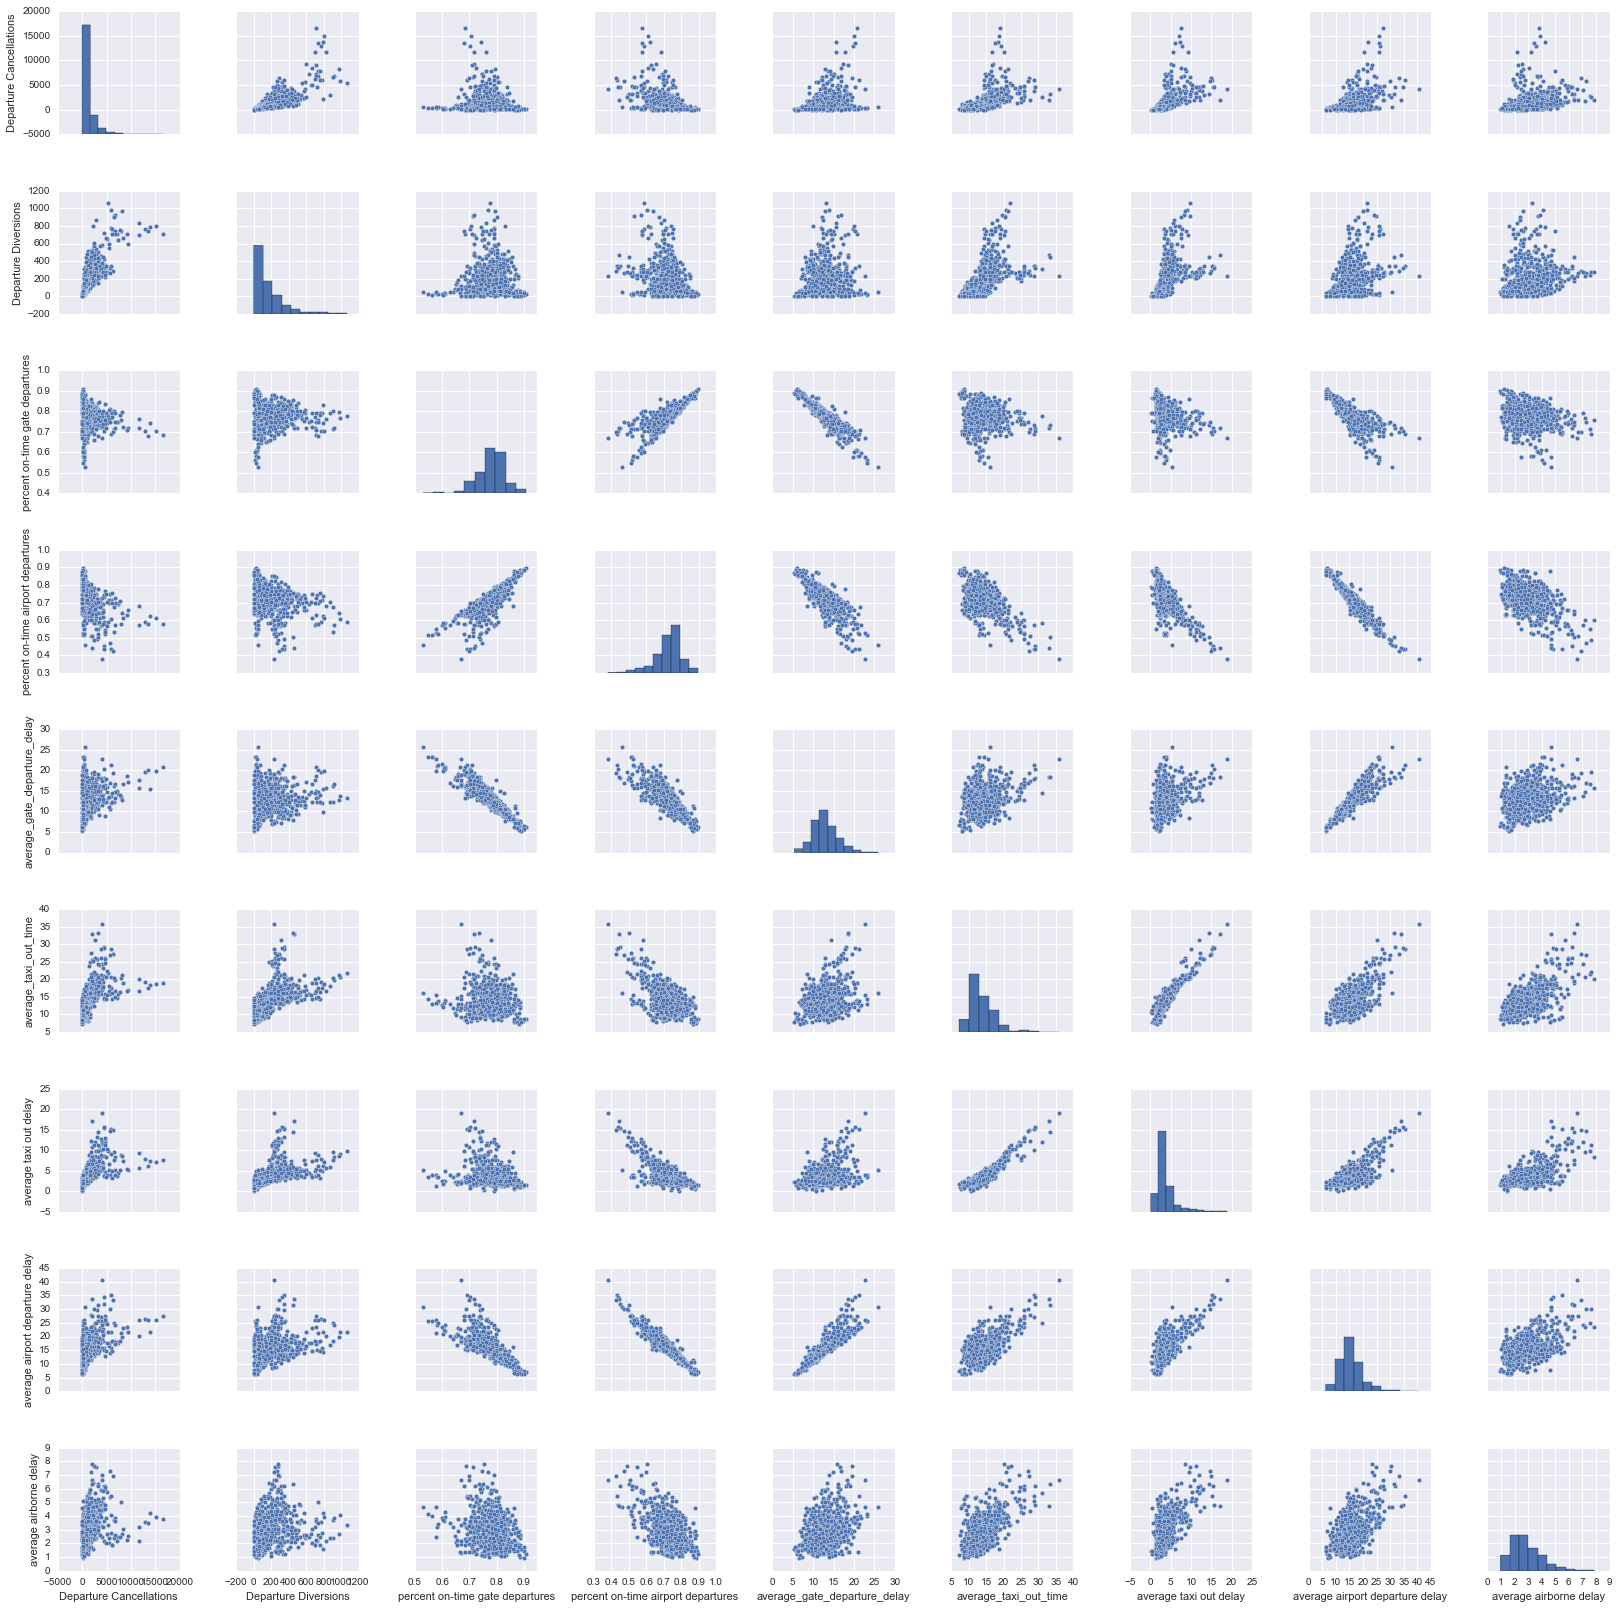

In [281]:
cols = [
 'Departure Cancellations',
 'Departure Diversions',
 'percent on-time gate departures',
 'percent on-time airport departures',
 'average_gate_departure_delay',
 'average_taxi_out_time',
 'average taxi out delay',
 'average airport departure delay',
 'average airborne delay']

plt.figure(figsize = (20,20))
sns.pairplot(merged_airport[cols])

In [292]:
#Correlation matrix of numerical data.

#It is interesting to see for Longitude and Latitude that as they increase, the percent on-time metrics go down
#and the delay times go up. Intuititively, this makes sense, like a weather effect. Or perhaps more flights fly
#to and from higher longitude and latitudes?

#Opting for Spearman R because a number of the features appear to have non-normal distributions...

merge_airport_data[num_cols].corr(method = 'spearmanr')

Year  Departure Cancellations  \
Year                                1.000000                -0.074954   
Departure Cancellations            -0.074954                 1.000000   
Arrival Cancellations              -0.071526                 0.997464   
Departure Diversions               -0.021804                 0.796385   
Arrival Diversions                 -0.035331                 0.792253   
departures for metric computation  -0.068488                 0.808959   
arrivals for metric computation    -0.067507                 0.809994   
percent on-time gate departures     0.002818                -0.183962   
percent on-time airport departures  0.056174                -0.466213   
percent on-time gate arrivals       0.135191                -0.113363   
average_gate_departure_delay        0.061650                 0.291753   
average_taxi_out_time              -0.052435                 0.566103   
average taxi out delay             -0.160599                 0.599671   
average airport departure delay    -0.023332                 0.504939   
average airborne delay             -0.334442                 0.376828   
average taxi in delay              -0.031265                 0.723515   
average block delay                -0.321256                 0.396928   
average gate arrival delay         -0.064928                 0.325605   
Latitude                            0.002632                 0.122349   
Longitude                          -0.004275                 0.159456   

                                    Arrival Cancellations  \
Year                                            -0.071526   
Departure Cancellations                          0.997464   
Arrival Cancellations                            1.000000   
Departure Diversions                             0.814378   
Arrival Diversions                               0.793773   
departures for metric computation                0.823676   
arrivals for metric computation                  0.824622   
percent on-time gate departures                 -0.172420   
percent on-time airport departures              -0.453081   
percent on-time gate arrivals                   -0.094130   
average_gate_departure_delay                     0.275300   
average_taxi_out_time                            0.559625   
average taxi out delay                           0.588159   
average airport departure delay                  0.487547   
average airborne delay                           0.367273   
average taxi in delay                            0.730266   
average block delay                              0.388365   
average gate arrival delay                       0.305527   
Latitude                                         0.122006   
Longitude                                        0.145081   

                                    Departure Diversions  Arrival Diversions  \
Year                                           -0.021804           -0.035331   
Departure Cancellations                         0.796385            0.792253   
Arrival Cancellations                           0.814378            0.793773   
Departure Diversions                            1.000000            0.840401   
Arrival Diversions                              0.840401            1.000000   
departures for metric computation               0.934147            0.798750   
arrivals for metric computation                 0.934035            0.799456   
percent on-time gate departures                -0.051995           -0.142091   
percent on-time airport departures             -0.357375           -0.431068   
percent on-time gate arrivals                   0.067575           -0.028064   
average_gate_departure_delay                    0.124451            0.218199   
average_taxi_out_time                           0.571622            0.558053   
average taxi out delay                          0.554316            0.581730   
average airport departure delay                 0.360954            0.444050   
average airborne delay  

In [301]:
#attempting to get p-values for above... given that a number of the ....
from scipy.stats import spearmanr

correlation = []

for i in merge_airport_data[num_cols]:
    for j in merge_airport_data[num_cols]:
        if i != j:
            correlation.append((i, j, spearmanr(merge_airport_data[i], merge_airport_data[j])[0], spearmanr(merge_airport_data[i], merge_airport_data[j])[1]))


In [304]:
correlation = pd.DataFrame(correlation, columns = ['Feature1', 'Feature2', 'Spearman Corr', 'P-Value'])

correlated = lambda x: True if x <= 0.05 else False

correlation['correlated'] = correlation['P-Value'].apply(correlated)

correlation

Feature1                            Feature2  \
0                       Year             Departure Cancellations   
1                       Year               Arrival Cancellations   
2                       Year                Departure Diversions   
3                       Year                  Arrival Diversions   
4                       Year   departures for metric computation   
5                       Year     arrivals for metric computation   
6                       Year     percent on-time gate departures   
7                       Year  percent on-time airport departures   
8                       Year       percent on-time gate arrivals   
9                       Year        average_gate_departure_delay   
10                      Year               average_taxi_out_time   
11                      Year              average taxi out delay   
12                      Year     average airport departure delay   
13                      Year              average airborne delay   
14                      Year               average taxi in delay   
15                      Year                 average block delay   
16                      Year          average gate arrival delay   
17                      Year                            Latitude   
18                      Year                           Longitude   
19   Departure Cancellations                                Year   
20   Departure Cancellations               Arrival Cancellations   
21   Departure Cancellations                Departure Diversions   
22   Departure Cancellations                  Arrival Diversions   
23   Departure Cancellations   departures for metric computation   
24   Departure Cancellations     arrivals for metric computation   
25   Departure Cancellations     percent on-time gate departures   
26   Departure Cancellations  percent on-time airport departures   
27   Departure Cancellations       percent on-time gate arrivals   
28   Departure Cancellations        average_gate_departure_delay   
29   Departure Cancellations               average_taxi_out_time   
..                       ...                                 ...   
350                 Latitude  percent on-time airport departures   
351                 Latitude       percent on-time gate arrivals   
352                 Latitude        average_gate_departure_delay   
353                 Latitude               average_taxi_out_time   
354                 Latitude              average taxi out delay   
355                 Latitude     average airport departure delay   
356                 Latitude              average airborne delay   
357                 Latitude               average taxi in delay   
358                 Latitude                 average block delay   
359                 Latitude          average gate arrival delay   
360                 Latitude                           Longitude   
361                Longitude                                Year   
362                Longitude             Departure Cancellations   
363                Longitude               Arrival Cancellations   
364                Longitude                Departure Diversions   
365                Longitude                  Arrival Diversions   
366                Longitude   departures for metric computation   
367                Longitude     arrivals for metric computation   
368                Longitude     percent on-time gate departures   
369                Longitude  percent on-time airport departures   
370                Longitude       percent on-time gate arrivals   
371                Longitude        average_gate_departure_delay   
372                Longitude               average_taxi_out_time   
373                Longitude              average taxi out delay   
374                Longitude     average airport departure delay   
375                Longitude              average airborne delay   
376                Longitude               average taxi in delay   
377     

#### 4.3 What is the p-value? What does this mean?

In [ ]:
'''The p-value here is the metric we are using to either reject or not reject the null hypothesis that
our results are from two non-correlated arrays. In other words, a p-value below our threshold means we reject
with a level of significance that our data comes from non-correlated arrays. So we say it is likely our data is
correlated.'''

#### 4.4 What is the value of understanding correlations before PCA?¶

In [ ]:
'''Given that PCA works off of creating a correlation matrix and transforming it so that the components
are not correlated, seeing which features in the dataset are highly correlated and hence colinear before
transformation into new components which may have more explanatory power is useful.'''

## Part 5: Perform a PCA and Present Findings

#### 5.1 Define your "X" and "Y" variables

In [388]:
'''So I have a conundrum. Many of my features are dummies that are binary. Many of my features 
are also not normal. My approach will be to perform PCA only on continuous variables that appear 
normal, so mainly the operations data variables below.

Since I am interesting in factors impacting delays - I am going to focus on departure delays here
as my y.

Another time, I suppose I could model Departure Cancellations as my y.

'''
merged_airport.columns

features_to_use = [u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay', u'Latitude', u'Longitude']

y = merged_airport_dummies[u'average airport departure delay']
X = merged_airport_dummies[features_to_use]

#### 5.2 Standardize the x values

In [392]:
#Is this pipelineable?

from sklearn.preprocessing import StandardScaler

stdscale = StandardScaler()

X_scaled = stdscale.fit_transform(X)

#### 5.3 Create the covariance matrix

In [393]:
X_covmat = np.cov(X_scaled.T)

#### Check the Eigenvalues and Eigenvectors

In [394]:
eig_vals, eig_vecs = np.linalg.eig(X_covmat)

In [385]:
print eig_vals
print '----------------------'
print eig_vecs

[  6.13904129e+00   2.17379831e+00   1.11380943e+00   8.26152683e-01
   6.06581925e-01   4.49779596e-01   3.16196536e-01   1.82728595e-01
   1.30326388e-01   5.65868262e-02   4.98431435e-03   1.50517016e-02]
----------------------
[[ -3.00344101e-01   3.73004015e-01  -3.40272781e-02   3.92129343e-03
    3.75652828e-01   2.53276254e-01  -1.23546927e-01  -2.98784403e-01
   -1.40943946e-01   2.39523869e-01  -5.86044533e-01   1.97492402e-01]
 [ -3.80803790e-01   2.55357231e-02  -2.76982238e-02   7.82152791e-02
    2.78606080e-01   2.10139221e-01   1.92567263e-01  -2.44846450e-01
   -2.73212695e-01  -1.22908056e-01   6.77721802e-01   2.82101748e-01]
 [ -3.13560371e-01   3.47274986e-01  -5.03867403e-02  -2.01626063e-01
   -2.37160403e-01  -1.20550183e-01   1.40055695e-01   2.87704196e-01
   -4.43143834e-01   3.83126659e-01   1.12087377e-01  -4.57160043e-01]
 [  3.37352788e-01  -3.05823240e-01   1.69259827e-02  -1.63756855e-02
   -2.51794735e-01  -2.87785549e-02   2.86137884e-02  -2.02661909e

#### 5.4 Print the Eigenpairs

In [395]:
eigen_pairs = [[eig_vals[i], eig_vecs[:,i]] for i in range(len(eig_vals))]
eigen_pairs.sort(reverse=True)

print eigen_pairs

eigenpairs = pd.DataFrame(eigen_pairs, columns = ['eigenvalue', 'eigenvector'])

eigenpairs

[[6.139041291760754, array([-0.3003441 , -0.38080379, -0.31356037,  0.33735279,  0.28923561,
        0.29979637,  0.25550968,  0.21331814,  0.29055281,  0.35337502,
        0.1081666 ,  0.21756632])], [2.1737983075747929, array([ 0.37300401,  0.02553572,  0.34727499, -0.30582324,  0.41847489,
        0.39876032,  0.2643587 ,  0.39026261,  0.15678028, -0.21052828,
        0.02169782, -0.14280649])], [1.1138094283859106, array([-0.03402728, -0.02769822, -0.05038674,  0.01692598,  0.03688068,
        0.02764352, -0.37994324,  0.31992281,  0.1215911 ,  0.03436544,
       -0.85277145,  0.05686209])], [0.82615268337447734, array([ 0.00392129,  0.07821528, -0.20162606, -0.01637569, -0.13450895,
       -0.10433093,  0.03485444, -0.01544204,  0.5089013 ,  0.1766726 ,
        0.00502911, -0.79517032])], [0.60658192528442967, array([ 0.37565283,  0.27860608, -0.2371604 , -0.25179474,  0.0563511 ,
        0.00855205,  0.21553314, -0.46560241,  0.39258738,  0.21132873,
       -0.19188666,  0.399404

eigenvalue                                        eigenvector
0     6.139041  [-0.300344101455, -0.380803789991, -0.31356037...
1     2.173798  [0.373004014777, 0.0255357230844, 0.3472749861...
2     1.113809  [-0.0340272781369, -0.0276982237878, -0.050386...
3     0.826153  [0.00392129342649, 0.0782152790978, -0.2016260...
4     0.606582  [0.375652827532, 0.278606079975, -0.2371604025...
5     0.449780  [0.253276253941, 0.210139221238, -0.1205501828...
6     0.316197  [-0.123546926639, 0.192567263053, 0.1400556952...
7     0.182729  [-0.298784403034, -0.244846449799, 0.287704195...
8     0.130326  [-0.140943946215, -0.27321269549, -0.443143834...
9     0.056587  [0.239523869229, -0.122908055693, 0.3831266591...
10    0.015052  [0.197492401754, 0.282101747515, -0.4571600431...
11    0.004984  [-0.586044532953, 0.677721802016, 0.1120873770...

#### 5.5 Calculate the explained variance

In [396]:
#sum all the eigenvalues together.
totaleig_val = eigenpairs.eigenvalue.sum()
print "Total Eigenvalue Sum is:", totaleig_val
print '-------------------'
indiv_var = [eigenpairs.eigenvalue[i]/totaleig_val*100 for i in range(len(eigenpairs))]
cum_exp_var = np.cumsum(indiv_var)

print 'Cumulative Variance Explained as we include principal components:', cum_exp_var
len(eigenpairs.eigenvalue)


Total Eigenvalue Sum is: 12.015037594
-------------------
Cumulative Variance Explained as we include principal components: [  51.09464905   69.18696287   78.45709141   85.33308057   90.38160348
   94.12507571   96.75674901   98.2775815    99.36227547   99.83324217
   99.95851603  100.        ]


12

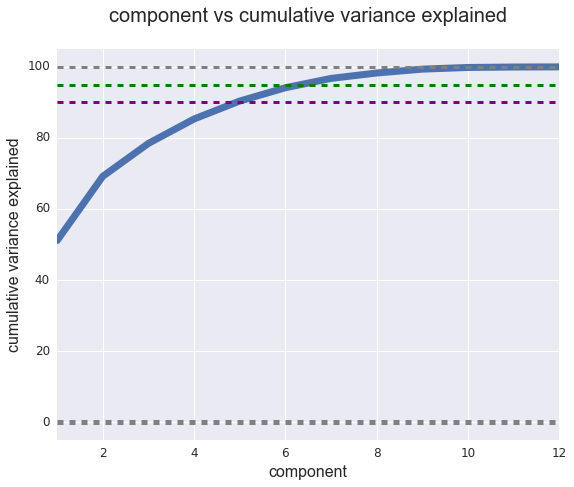

Cumulative variance explained at Component 12: 100.0
Cumulative variance explained at Component 6: 94.1250757142
Cumulative variance explained at Component 5: 90.3816034818


In [399]:
plt.figure(figsize=(9,7))

component_number = range(1,13)

plt.plot(component_number, cum_exp_var, lw=7)

plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
plt.axhline(y=95, linewidth = 3, color = 'green', ls = 'dashed')
plt.axhline(y=90, linewidth = 3, color = 'purple', ls = 'dashed')

ax = plt.gca()
ax.set_xlim([1,12])
ax.set_ylim([-5,105])

ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

'''At component 12, we seem to explain most if not all of our variance. 99.56% to be exact.
At component 7, it looks like we explain 95% of our variance. At component 6, we explain 90% of variance.'''

print "Cumulative variance explained at Component 12:", cum_exp_var[11]
print "Cumulative variance explained at Component 6:", cum_exp_var[5]
print "Cumulative variance explained at Component 5:", cum_exp_var[4]


In [ ]:
'''Based on the above, I will use five components for my PCA, as 90% of variance is explained.'''

#### 5.6 Conduct the PCA

In [400]:
depart_delay_pca = PCA(n_components= 5)

merged_airports_pca = depart_delay_pca.fit_transform(X_scaled)

#### 5.7 Create a dataframe from the PCA results

In [401]:
merged_airports_pca_df = pd.DataFrame(merged_airports_pca, columns = ['PC_' + str(i) for i in range(1,6)])
merged_airports_pca_df.head()

PC_1      PC_2      PC_3      PC_4      PC_5
0 -2.186129  0.272998  0.182286 -0.094810 -0.009408
1 -2.626941  0.102214  0.153547  0.060088 -0.057687
2 -1.943520  0.637620  0.022626 -0.266443  0.017764
3 -1.411533  0.419451 -0.201834 -0.519979  0.015569
4 -2.087575  0.293694 -0.142253 -0.231635 -0.040906

Now, create a new dataframe that uses the airport and year from the original set and join the PCA results with it to form a new set

In [402]:
#Making the decision to also include the region and airport type in the data for the simple
#reason that these were not used for PCA...

#categoricals to include
#cat_cols
cat_cols_include = [u'Airport', u'FAA REGION_ACE', u'FAA REGION_AEA', u'FAA REGION_AGL',
       u'FAA REGION_ANE', u'FAA REGION_ANM', u'FAA REGION_ASO',
       u'FAA REGION_ASW', u'FAA REGION_AWP', u'AP Type_Public Use', u'Year']

airports_pca_dummies = pd.merge(merged_airport_dummies[cat_cols_include], merged_airports_pca_df, left_index = True, right_index = True)

#### 5.8 Graph the results to a new feature space

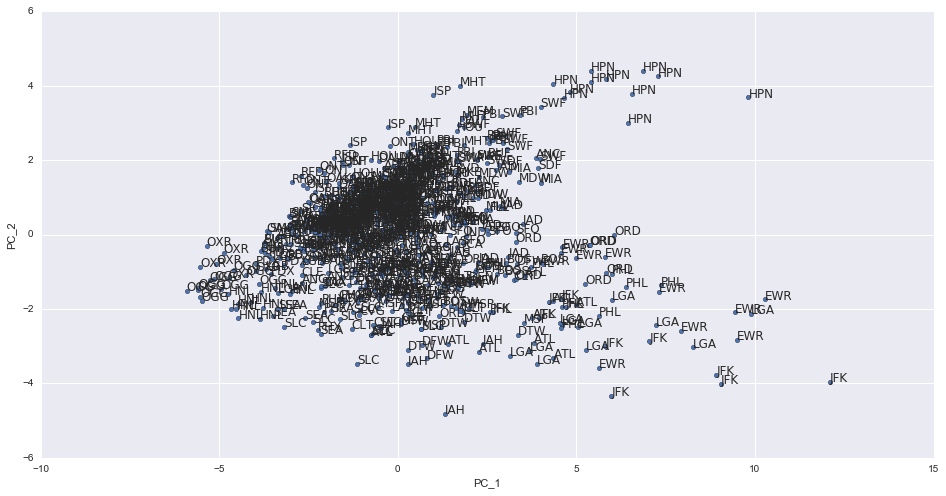

In [416]:
#Since I have five PCs, will create multiple graphs
#PC 1 and PC2

graphpc1pc2 = airports_pca_dummies.plot(kind = 'scatter', x = 'PC_1', y = 'PC_2', figsize = (16,8))

for i, airport in enumerate(merged_airport['Airport']):
    graphpc1pc2.annotate(airport, (airports_pca_dummies.iloc[i].PC_1, airports_pca_dummies.iloc[i].PC_2))

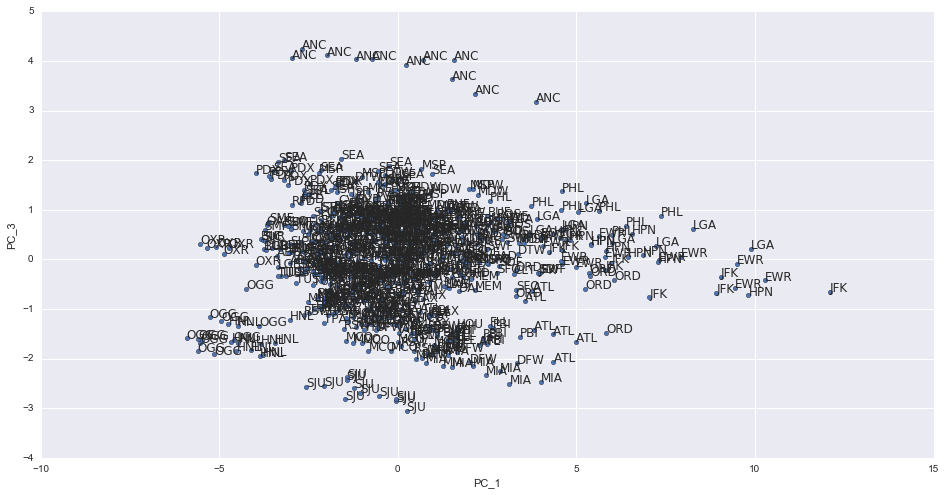

In [417]:
#PC 1 and PC 3
graphpc1pc3 = airports_pca_dummies.plot(kind = 'scatter', x = 'PC_1', y = 'PC_3', figsize = (16,8))

for i, airport in enumerate(merged_airport['Airport']):
    graphpc1pc3.annotate(airport, (airports_pca_dummies.iloc[i].PC_1, airports_pca_dummies.iloc[i].PC_3))

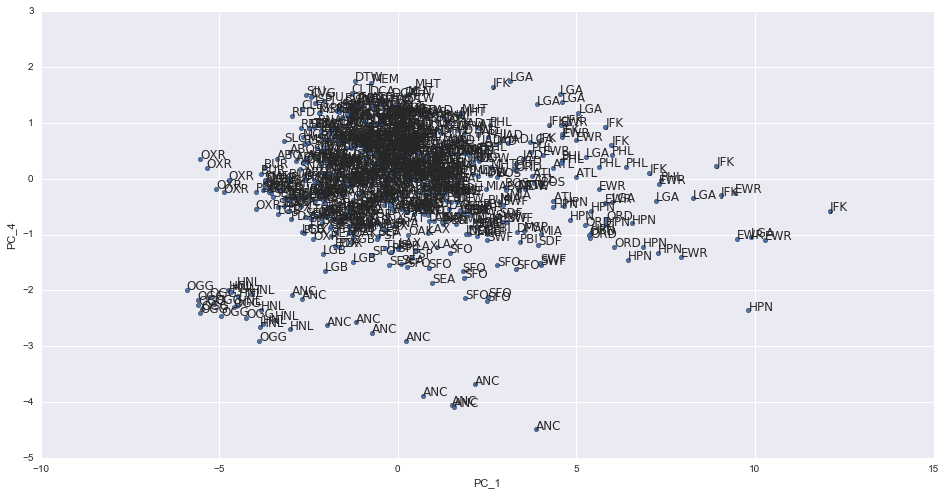

In [418]:
#PC 1 and PC 4
graphpc1pc4 = airports_pca_dummies.plot(kind = 'scatter', x = 'PC_1', y = 'PC_4', figsize = (16,8))

for i, airport in enumerate(merged_airport['Airport']):
    graphpc1pc4.annotate(airport, (airports_pca_dummies.iloc[i].PC_1, airports_pca_dummies.iloc[i].PC_4))

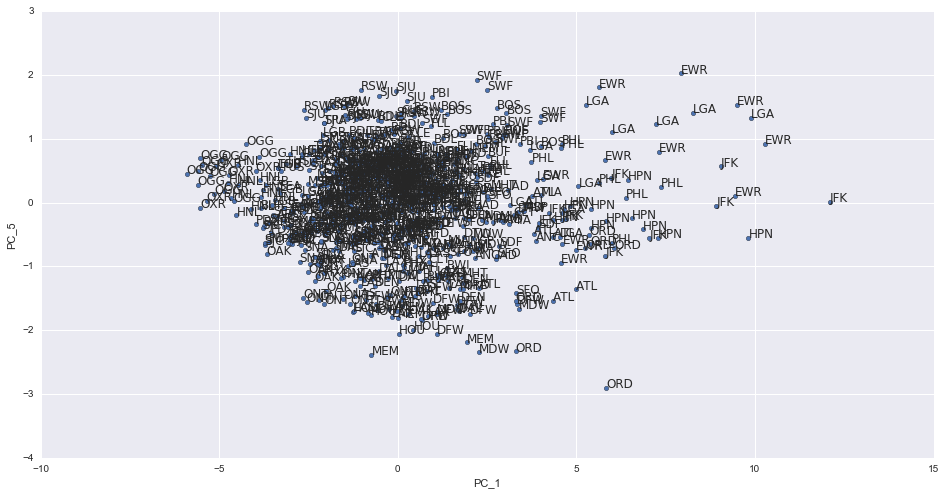

In [420]:
#PC 1 and PC 5
graphpc1pc5 = airports_pca_dummies.plot(kind = 'scatter', x = 'PC_1', y = 'PC_5', figsize = (16,8))

for i, airport in enumerate(merged_airport['Airport']):
    graphpc1pc5.annotate(airport, (airports_pca_dummies.iloc[i].PC_1, airports_pca_dummies.iloc[i].PC_5))

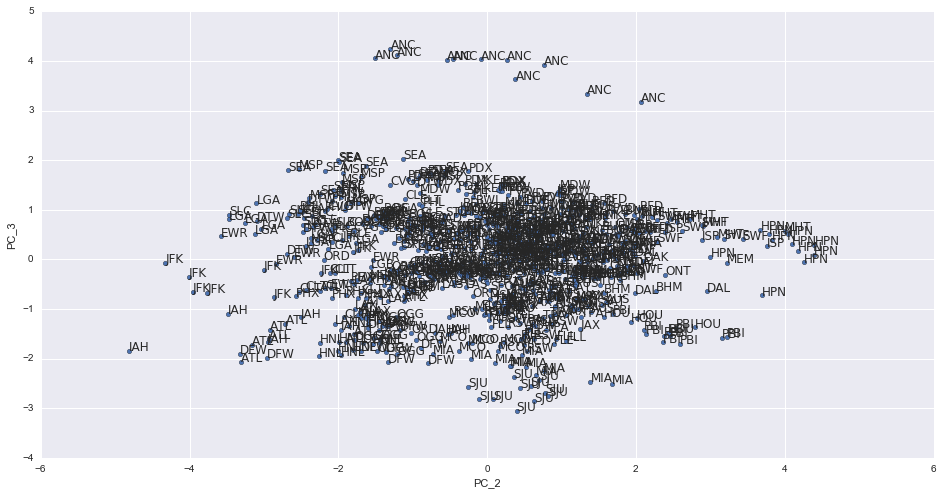

In [423]:
#PC 2 and PC 3
graphpc2pc3 = airports_pca_dummies.plot(kind = 'scatter', x = 'PC_2', y = 'PC_3', figsize = (16,8))

for i, airport in enumerate(merged_airport['Airport']):
    graphpc2pc3.annotate(airport, (airports_pca_dummies.iloc[i].PC_2, airports_pca_dummies.iloc[i].PC_3))

In [427]:
features= [u'FAA REGION_ACE', u'FAA REGION_AEA', u'FAA REGION_AGL',
       u'FAA REGION_ANE', u'FAA REGION_ANM', u'FAA REGION_ASO',
       u'FAA REGION_ASW', u'FAA REGION_AWP', u'AP Type_Public Use', u'PC_1',
                     u'PC_2',               u'PC_3',               u'PC_4',
                     u'PC_5']


In [430]:
#Running a quick linear regression...

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
lm = LinearRegression()
lasso = LassoCV(random_state = 31, n_jobs = -1, verbose = True)

X_train, X_test, y_train, y_test = train_test_split(airports_pca_dummies[features], y, test_size = .25, random_state = 31)

lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_test)

print "R2 score for Linear Regression is:", r2_score(y_test, y_pred_lm)

#airports_pca_dummies

R2 score for Linear Regression is: 0.964597754634


In [437]:
print "Intercept is:", lm.intercept_
print "Coefficients for LR are below in a DF."
pd.DataFrame(lm.coef_, index = airports_pca_dummies[features].columns)


'''Interestingly, every region other than the first one reduces the minutes of airport departure delay.'''

Intercept is: 19.2063297147
Coefficients for LR are below in a DF.


'Interestingly, every region other than the first one reduces the minutes of airport departure delay.'

In [438]:
#Lasso regression on principal components...

lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print "R2 score for Lasso CV Regression is:", r2_score(y_test, y_pred_lasso)

print "Intercept is:", lasso.intercept_
print "Coefficients for LR are below in a DF."
pd.DataFrame(lasso.coef_, index = airports_pca_dummies[features].columns)

R2 score for Lasso CV Regression is: 0.960834652868
Intercept is: 15.7351893293
Coefficients for LR are below in a DF.


............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


0
FAA REGION_ACE     -0.000000
FAA REGION_AEA      0.145053
FAA REGION_AGL     -0.248698
FAA REGION_ANE      0.000000
FAA REGION_ANM     -0.377643
FAA REGION_ASO     -0.000000
FAA REGION_ASW     -0.021190
FAA REGION_AWP      0.066559
AP Type_Public Use  0.000000
PC_1                1.696914
PC_2                0.081837
PC_3               -0.067868
PC_4                0.281914
PC_5               -0.853355

From the above, we can see that with a Lasso CV, four out of the nine FAA regions have coefficients of zero, so there is a regional impact on airport departure delay time.

We can also see that all the principal components stayed in, and that our R2 was quite high. Either this is amazing or suspect.

#### 5.9 Write an analysis plan of your findings

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps

Out of 12 features, we reduced our dimensions for our continuous variables down to five.

Next steps would be to 
1) examine these components with regard to a specific airport;
2) perform clustering analysis to see if in the new feature space we can see commonalities among airports for delays;
3) extend the analysis to arrival delays.

## Bonus:

#### 1. Conduct the analysis again using different variables from the airport_operations.csv dataset

#### 2. Create visualization of your data using the ggplot features of matplotlib